In [1]:
import re
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.colors as mcolors
from matplotlib.ticker import FuncFormatter
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
import shap
import tensorflow as tf
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import pickle
import numpy as np
from lime.lime_tabular import LimeTabularExplainer
from tqdm import tqdm

from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


## Data Preparation

In [2]:
df = pd.read_csv('../Data/STAGE 4 FINAL MERGED DATA/STAGE_4_MERGED_FINAL_ENCODED.csv')

In [3]:
df

,klasifikasi_perkara_encoded,penuntut_umum_encoded,hakim_encoded,jumlah_saksi,maks_penjara_berdasarkan_pasal,terdakwa,summarized_dakwaan,total_pidana_penjara_bulan
0,0,0,0,6,80,GEDE DARMAYASA,Terdakwa Gede Darmayasa didakwa telah melakuka...,5.0
1,1,1,1,4,48,IDA BAGUS MADE DARMA WIGUNA,"Pada bulan Februari dan Maret 2024, terdakwa I...",24.0
2,0,0,2,6,84,HANDRI JOHANAS,"Terdakwa Handri Johanes pada Rabu, 24 April 20...",4.0
3,2,2,1,2,144,I GEDE ARIADI alias BERNAD,"Pada hari Minggu, 14 April 2024 sekitar pukul ...",14.0
4,2,3,1,2,144,I GEDE ARIADI alias BERNAD,"Pada hari Minggu, 14 April 2024 sekitar pukul ...",14.0
...,...,...,...,...,...,...,...,...
4318,2,269,118,2,240,NURUL FIQRI SUDIRMAN als KIKI bin SUDIRMAN,"Pada Jumat, 31 Maret 2023, sekitar pukul 20.30...",72.0
4319,0,257,107,2,84,SUPRIADI BIN RATIM,"Pada hari Minggu, 28 Mei 2023, sekitar pukul 1...",16.0
4320,0,280,107,2,84,SUPRIADI BIN RATIM,"Pada hari Minggu, 28 Mei 2023, sekitar pukul 1...",16.0
4321,0,257,107,2,84,ANWAR RURI BIN SYARIFUDIN USMAN,"Pada hari Minggu, 28 Mei 2023, sekitar pukul 1...",16.0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4323 entries, 0 to 4322
Data columns (total 8 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   klasifikasi_perkara_encoded     4323 non-null   int64  
 1   penuntut_umum_encoded           4323 non-null   int64  
 2   hakim_encoded                   4323 non-null   int64  
 3   jumlah_saksi                    4323 non-null   int64  
 4   maks_penjara_berdasarkan_pasal  4323 non-null   int64  
 5   terdakwa                        4323 non-null   object 
 6   summarized_dakwaan              4323 non-null   object 
 7   total_pidana_penjara_bulan      4323 non-null   float64
dtypes: float64(1), int64(5), object(2)
memory usage: 270.3+ KB


### Split Data

In [5]:
def stratified_split(df: pd.DataFrame, split_size: float = 0.8) -> tuple[pd.DataFrame, pd.DataFrame]:
    unique_groups = df.groupby(["klasifikasi_perkara_encoded", "penuntut_umum_encoded", "hakim_encoded"]).apply(lambda x: x.index.tolist()).to_dict()
    
    print(unique_groups)
    train_idx, test_idx = [], []
    
    for indices in unique_groups.values():        
        if len(indices) == 1:
            train_idx.extend(indices)
        else:
            train, test = train_test_split(indices, train_size=split_size, random_state=42)
            train_idx.extend(train)
            test_idx.extend(test)
    
    return df.loc[train_idx], df.loc[test_idx]

In [6]:
train_df, test_df = stratified_split(df)

{(0, 0, 0): [0, 20, 42], (0, 0, 2): [2], (0, 1, 0): [19, 37], (0, 1, 4): [35, 36], (0, 4, 1): [5], (0, 4, 3): [10], (0, 5, 21): [843], (0, 7, 1): [9], (0, 8, 0): [15, 17], (0, 9, 0): [16, 18], (0, 11, 4): [22, 23], (0, 12, 19): [775, 776, 813], (0, 12, 21): [774], (0, 12, 22): [715], (0, 12, 23): [806], (0, 13, 0): [32], (0, 13, 3): [34], (0, 14, 0): [38], (0, 14, 14): [437, 501, 595, 609], (0, 14, 16): [422], (0, 14, 18): [474, 665], (0, 14, 19): [783, 784, 785, 786], (0, 14, 20): [432, 438, 518, 578, 608, 724, 745], (0, 14, 21): [639, 822], (0, 15, 4): [33], (0, 16, 0): [39], (0, 17, 0): [40, 41], (0, 19, 7): [46], (0, 20, 36): [1051], (0, 21, 52): [1612], (0, 21, 54): [1630, 1632], (0, 22, 10): [241, 268, 269, 270, 271, 303], (0, 22, 14): [259, 381, 415, 416, 538, 545, 577, 621], (0, 22, 16): [308, 314, 315, 383, 386, 417], (0, 22, 18): [654, 655, 656], (0, 22, 19): [548, 762], (0, 22, 20): [446, 570, 571, 572, 573, 690, 725], (0, 22, 22): [719], (0, 23, 10): [52, 54], (0, 24, 10): 

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.


In [7]:
jenis_klasifikasi_perkara = train_df['klasifikasi_perkara_encoded'].unique()
jumlah_klasifikasi_perkara = len(jenis_klasifikasi_perkara)
print(f"Jumlah Klasifikasi Perkara: {jumlah_klasifikasi_perkara}")
print(f"Jumlah Data Train:  {len(train_df)}")

klasifikasi_perkara_values = train_df['klasifikasi_perkara_encoded'].value_counts()
print(klasifikasi_perkara_values)

Jumlah Klasifikasi Perkara: 5
Jumlah Data Train:  3270
klasifikasi_perkara_encoded
0    1378
2    1250
3     287
4     193
1     162
Name: count, dtype: int64


In [8]:
jenis_klasifikasi_perkara = test_df['klasifikasi_perkara_encoded'].unique()
jumlah_klasifikasi_perkara = len(jenis_klasifikasi_perkara)
print(f"Jumlah Klasifikasi Perkara: {jumlah_klasifikasi_perkara}")
print(f"Jumlah Data Test:  {len(test_df)}")

klasifikasi_perkara_values = test_df['klasifikasi_perkara_encoded'].value_counts()
print(klasifikasi_perkara_values)

Jumlah Klasifikasi Perkara: 5
Jumlah Data Test:  1053
klasifikasi_perkara_encoded
0    490
2    439
4     51
3     50
1     23
Name: count, dtype: int64


## Model

In [9]:
model_scenario_name = "BiLSTM_12"
max_len = 1024

model_save_path = f'../Model/{model_scenario_name}'
tokenizer_save_path = f'../Model/{model_scenario_name}_tokenizer.pkl'
history_training_save_path = f'../Model/{model_scenario_name}_training_history.pkl'
    
loaded_model = tf.keras.models.load_model(model_save_path)

with open(tokenizer_save_path, 'rb') as handle:
    tokenizer = pickle.load(handle)

### Model Preprocessing

In [10]:
train_df['concat_text'] = train_df[['terdakwa', 'summarized_dakwaan']].apply(lambda x: '. '.join(x), axis=1)
test_df['concat_text'] = test_df[['terdakwa', 'summarized_dakwaan']].apply(lambda x: '. '.join(x), axis=1)

In [11]:
y_train = train_df['total_pidana_penjara_bulan']
y_test = test_df['total_pidana_penjara_bulan']

### Normalisasi

In [12]:
def normalize_text(text):
    text = text.lower()
    text = re.sub(r'[^a-z0-9\s\(\)]', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text

train_df['normalized_text'] = train_df['concat_text'].apply(normalize_text)
test_df['normalized_text'] = test_df['concat_text'].apply(normalize_text)

### Stopwords Removal

In [13]:
stopword_factory = StopWordRemoverFactory()
stop_words = set(stopword_factory.get_stop_words())

def remove_stopwords(text, stop_words):
    return ' '.join([word for word in text.split() if word not in stop_words])

train_df['stopword_removal'] = train_df['normalized_text'].apply(lambda x: remove_stopwords(x, stop_words))
test_df['stopword_removal'] = test_df['normalized_text'].apply(lambda x: remove_stopwords(x, stop_words))

### Tokenizer

In [14]:
# Tokenisasi
train_sequences = tokenizer.texts_to_sequences(train_df['stopword_removal'])
test_sequences = tokenizer.texts_to_sequences(test_df['stopword_removal'])

In [15]:
# Padding
max_len = 1024
X_train_texts = tf.keras.preprocessing.sequence.pad_sequences(train_sequences, maxlen=max_len, padding='post', truncating='post')
X_test_texts = tf.keras.preprocessing.sequence.pad_sequences(test_sequences, maxlen=max_len, padding='post', truncating='post')

In [16]:
train_numerical = train_df[['klasifikasi_perkara_encoded', 'penuntut_umum_encoded', 'hakim_encoded', 'jumlah_saksi', 'maks_penjara_berdasarkan_pasal']].values
test_numerical = test_df[['klasifikasi_perkara_encoded', 'penuntut_umum_encoded', 'hakim_encoded', 'jumlah_saksi', 'maks_penjara_berdasarkan_pasal']].values

In [17]:
def model_predict(inputs):
    return loaded_model.predict([inputs[0], inputs[1]])

In [18]:
train_numerical

array([[  0,   0,   0,   4,  60],
       [  0,   0,   0,  15, 112],
       [  0,   0,   2,   6,  84],
       ...,
       [  4, 285, 118,   2, 120],
       [  4, 285, 121,   2, 120],
       [  4, 285, 124,   2, 120]], dtype=int64)

In [19]:
from lime.lime_tabular import LimeTabularExplainer
import numpy as np
from tqdm import tqdm

# Daftar fitur kategori: semua kolom karena semua hasil label encoding
categorical_features = [0, 1, 2, 3, 4]

explainer = LimeTabularExplainer(
    training_data=train_numerical,
    mode="regression",
    feature_names=['klasifikasi_perkara_encoded', 'penuntut_umum_encoded', 'hakim_encoded', 'jumlah_saksi', 'maks_penjara_berdasarkan_pasal'],
    categorical_features=categorical_features,
    verbose=False
)

all_explanations = []

for i in tqdm(range(len(test_numerical))):
    data_row = test_numerical[i]
    predict_fn = lambda x: loaded_model.predict([np.tile(X_test_texts[i], (x.shape[0], 1)), x])

    explanation = explainer.explain_instance(
        data_row=data_row,
        predict_fn=predict_fn
    )
    all_explanations.append(explanation)

# Tampilkan hasil untuk instance pertama
all_explanations[0].show_in_notebook()


  0%|          | 0/1053 [00:00<?, ?it/s]

157/157 [==============================] - 18s 99ms/step


  0%|          | 1/1053 [00:17<5:10:51, 17.73s/it]

157/157 [==============================] - 15s 96ms/step


  0%|          | 2/1053 [00:32<4:44:39, 16.25s/it]

157/157 [==============================] - 16s 100ms/step


  0%|          | 3/1053 [00:48<4:40:09, 16.01s/it]

157/157 [==============================] - 16s 100ms/step


  0%|          | 4/1053 [01:04<4:38:24, 15.92s/it]

157/157 [==============================] - 16s 100ms/step


  0%|          | 5/1053 [01:20<4:37:06, 15.86s/it]

157/157 [==============================] - 16s 100ms/step


  1%|          | 6/1053 [01:36<4:36:25, 15.84s/it]

157/157 [==============================] - 16s 101ms/step


  1%|          | 7/1053 [01:51<4:36:32, 15.86s/it]

157/157 [==============================] - 16s 100ms/step


  1%|          | 8/1053 [02:07<4:36:10, 15.86s/it]

157/157 [==============================] - 16s 101ms/step


  1%|          | 9/1053 [02:23<4:35:58, 15.86s/it]

157/157 [==============================] - 16s 101ms/step


  1%|          | 10/1053 [02:39<4:35:43, 15.86s/it]

157/157 [==============================] - 16s 101ms/step


  1%|          | 11/1053 [02:55<4:35:42, 15.88s/it]

157/157 [==============================] - 16s 100ms/step


  1%|          | 12/1053 [03:11<4:35:07, 15.86s/it]

157/157 [==============================] - 16s 101ms/step


  1%|          | 13/1053 [03:27<4:34:52, 15.86s/it]

157/157 [==============================] - 16s 101ms/step


  1%|▏         | 14/1053 [03:43<4:35:08, 15.89s/it]

157/157 [==============================] - 16s 100ms/step


  1%|▏         | 15/1053 [03:58<4:33:57, 15.84s/it]

157/157 [==============================] - 16s 100ms/step


  2%|▏         | 16/1053 [04:14<4:33:22, 15.82s/it]

157/157 [==============================] - 15s 95ms/step


  2%|▏         | 17/1053 [04:29<4:28:27, 15.55s/it]

157/157 [==============================] - 15s 95ms/step


  2%|▏         | 18/1053 [04:44<4:25:08, 15.37s/it]

157/157 [==============================] - 16s 103ms/step


  2%|▏         | 19/1053 [05:00<4:29:01, 15.61s/it]

157/157 [==============================] - 16s 101ms/step


  2%|▏         | 20/1053 [05:16<4:30:30, 15.71s/it]

157/157 [==============================] - 16s 101ms/step


  2%|▏         | 21/1053 [05:32<4:31:11, 15.77s/it]

157/157 [==============================] - 16s 101ms/step


  2%|▏         | 22/1053 [05:48<4:32:01, 15.83s/it]

157/157 [==============================] - 16s 99ms/step


  2%|▏         | 23/1053 [06:04<4:30:59, 15.79s/it]

157/157 [==============================] - 16s 100ms/step


  2%|▏         | 24/1053 [06:19<4:30:48, 15.79s/it]

157/157 [==============================] - 16s 102ms/step


  2%|▏         | 25/1053 [06:35<4:31:42, 15.86s/it]

157/157 [==============================] - 16s 101ms/step


  2%|▏         | 26/1053 [06:51<4:31:25, 15.86s/it]

157/157 [==============================] - 16s 100ms/step


  3%|▎         | 27/1053 [07:07<4:30:23, 15.81s/it]

157/157 [==============================] - 16s 100ms/step


  3%|▎         | 28/1053 [07:23<4:30:17, 15.82s/it]

157/157 [==============================] - 16s 101ms/step


  3%|▎         | 29/1053 [07:39<4:30:12, 15.83s/it]

157/157 [==============================] - 16s 100ms/step


  3%|▎         | 30/1053 [07:54<4:29:21, 15.80s/it]

157/157 [==============================] - 16s 102ms/step


  3%|▎         | 31/1053 [08:10<4:30:18, 15.87s/it]

157/157 [==============================] - 15s 96ms/step


  3%|▎         | 32/1053 [08:26<4:26:04, 15.64s/it]

157/157 [==============================] - 15s 96ms/step


  3%|▎         | 33/1053 [08:41<4:23:10, 15.48s/it]

157/157 [==============================] - 15s 95ms/step


  3%|▎         | 34/1053 [08:56<4:20:21, 15.33s/it]

157/157 [==============================] - 15s 95ms/step


  3%|▎         | 35/1053 [09:11<4:18:20, 15.23s/it]

157/157 [==============================] - 15s 94ms/step


  3%|▎         | 36/1053 [09:25<4:16:19, 15.12s/it]

157/157 [==============================] - 15s 94ms/step


  4%|▎         | 37/1053 [09:40<4:14:44, 15.04s/it]

157/157 [==============================] - 15s 95ms/step


  4%|▎         | 38/1053 [09:55<4:13:54, 15.01s/it]

157/157 [==============================] - 16s 100ms/step


  4%|▎         | 39/1053 [10:11<4:17:15, 15.22s/it]

157/157 [==============================] - 16s 100ms/step


  4%|▍         | 40/1053 [10:27<4:19:55, 15.40s/it]

157/157 [==============================] - 16s 100ms/step


  4%|▍         | 41/1053 [10:43<4:21:54, 15.53s/it]

157/157 [==============================] - 16s 100ms/step


  4%|▍         | 42/1053 [10:58<4:22:33, 15.58s/it]

157/157 [==============================] - 16s 100ms/step


  4%|▍         | 43/1053 [11:14<4:23:37, 15.66s/it]

157/157 [==============================] - 16s 101ms/step


  4%|▍         | 44/1053 [11:30<4:24:28, 15.73s/it]

157/157 [==============================] - 16s 100ms/step


  4%|▍         | 45/1053 [11:46<4:24:26, 15.74s/it]

157/157 [==============================] - 16s 100ms/step


  4%|▍         | 46/1053 [12:02<4:24:25, 15.76s/it]

157/157 [==============================] - 15s 95ms/step


  4%|▍         | 47/1053 [12:17<4:20:01, 15.51s/it]

157/157 [==============================] - 15s 94ms/step


  5%|▍         | 48/1053 [12:31<4:16:36, 15.32s/it]

157/157 [==============================] - 15s 94ms/step


  5%|▍         | 49/1053 [12:46<4:14:09, 15.19s/it]

157/157 [==============================] - 16s 99ms/step


  5%|▍         | 50/1053 [13:02<4:16:17, 15.33s/it]

157/157 [==============================] - 16s 99ms/step


  5%|▍         | 51/1053 [13:18<4:17:44, 15.43s/it]

157/157 [==============================] - 16s 101ms/step


  5%|▍         | 52/1053 [13:34<4:20:03, 15.59s/it]

157/157 [==============================] - 16s 102ms/step


  5%|▌         | 53/1053 [13:50<4:21:58, 15.72s/it]

157/157 [==============================] - 16s 100ms/step


  5%|▌         | 54/1053 [14:05<4:22:09, 15.75s/it]

157/157 [==============================] - 16s 100ms/step


  5%|▌         | 55/1053 [14:21<4:22:14, 15.77s/it]

157/157 [==============================] - 16s 100ms/step


  5%|▌         | 56/1053 [14:37<4:22:14, 15.78s/it]

157/157 [==============================] - 16s 100ms/step


  5%|▌         | 57/1053 [14:53<4:22:04, 15.79s/it]

157/157 [==============================] - 16s 100ms/step


  6%|▌         | 58/1053 [15:09<4:21:39, 15.78s/it]

157/157 [==============================] - 16s 101ms/step


  6%|▌         | 59/1053 [15:24<4:21:49, 15.80s/it]

157/157 [==============================] - 16s 102ms/step


  6%|▌         | 60/1053 [15:41<4:22:53, 15.88s/it]

157/157 [==============================] - 16s 101ms/step


  6%|▌         | 61/1053 [15:57<4:22:57, 15.91s/it]

157/157 [==============================] - 16s 101ms/step


  6%|▌         | 62/1053 [16:12<4:22:32, 15.90s/it]

157/157 [==============================] - 16s 100ms/step


  6%|▌         | 63/1053 [16:28<4:21:48, 15.87s/it]

157/157 [==============================] - 15s 95ms/step


  6%|▌         | 64/1053 [16:43<4:17:10, 15.60s/it]

157/157 [==============================] - 15s 97ms/step


  6%|▌         | 65/1053 [16:58<4:15:12, 15.50s/it]

157/157 [==============================] - 16s 101ms/step


  6%|▋         | 66/1053 [17:14<4:16:40, 15.60s/it]

157/157 [==============================] - 16s 101ms/step


  6%|▋         | 67/1053 [17:30<4:18:05, 15.71s/it]

157/157 [==============================] - 16s 100ms/step


  6%|▋         | 68/1053 [17:46<4:18:01, 15.72s/it]

157/157 [==============================] - 16s 100ms/step


  7%|▋         | 69/1053 [18:02<4:18:21, 15.75s/it]

157/157 [==============================] - 16s 100ms/step


  7%|▋         | 70/1053 [18:18<4:18:27, 15.78s/it]

157/157 [==============================] - 16s 100ms/step


  7%|▋         | 71/1053 [18:33<4:18:28, 15.79s/it]

157/157 [==============================] - 16s 99ms/step


  7%|▋         | 72/1053 [18:49<4:17:32, 15.75s/it]

157/157 [==============================] - 16s 100ms/step


  7%|▋         | 73/1053 [19:05<4:17:38, 15.77s/it]

157/157 [==============================] - 16s 100ms/step


  7%|▋         | 74/1053 [19:21<4:17:17, 15.77s/it]

157/157 [==============================] - 16s 100ms/step


  7%|▋         | 75/1053 [19:37<4:17:19, 15.79s/it]

157/157 [==============================] - 16s 100ms/step


  7%|▋         | 76/1053 [19:52<4:17:13, 15.80s/it]

157/157 [==============================] - 16s 100ms/step


  7%|▋         | 77/1053 [20:08<4:16:43, 15.78s/it]

157/157 [==============================] - 16s 101ms/step


  7%|▋         | 78/1053 [20:24<4:16:47, 15.80s/it]

157/157 [==============================] - 15s 96ms/step


  8%|▊         | 79/1053 [20:39<4:13:33, 15.62s/it]

157/157 [==============================] - 16s 100ms/step


  8%|▊         | 80/1053 [20:55<4:13:43, 15.65s/it]

157/157 [==============================] - 16s 99ms/step


  8%|▊         | 81/1053 [21:11<4:13:38, 15.66s/it]

157/157 [==============================] - 16s 99ms/step


  8%|▊         | 82/1053 [21:26<4:13:15, 15.65s/it]

157/157 [==============================] - 16s 100ms/step


  8%|▊         | 83/1053 [21:42<4:13:28, 15.68s/it]

157/157 [==============================] - 16s 100ms/step


  8%|▊         | 84/1053 [21:58<4:13:56, 15.72s/it]

157/157 [==============================] - 16s 100ms/step


  8%|▊         | 85/1053 [22:13<4:13:41, 15.72s/it]

157/157 [==============================] - 16s 100ms/step


  8%|▊         | 86/1053 [22:29<4:13:39, 15.74s/it]

157/157 [==============================] - 16s 101ms/step


  8%|▊         | 87/1053 [22:45<4:13:58, 15.77s/it]

157/157 [==============================] - 16s 100ms/step


  8%|▊         | 88/1053 [23:01<4:14:04, 15.80s/it]

157/157 [==============================] - 16s 100ms/step


  8%|▊         | 89/1053 [23:17<4:13:30, 15.78s/it]

157/157 [==============================] - 16s 99ms/step


  9%|▊         | 90/1053 [23:32<4:12:45, 15.75s/it]

157/157 [==============================] - 16s 100ms/step


  9%|▊         | 91/1053 [23:48<4:12:28, 15.75s/it]

157/157 [==============================] - 16s 100ms/step


  9%|▊         | 92/1053 [24:04<4:12:02, 15.74s/it]

157/157 [==============================] - 16s 99ms/step


  9%|▉         | 93/1053 [24:19<4:11:29, 15.72s/it]

157/157 [==============================] - 16s 100ms/step


  9%|▉         | 94/1053 [24:35<4:11:49, 15.76s/it]

157/157 [==============================] - 16s 102ms/step


  9%|▉         | 95/1053 [24:51<4:13:21, 15.87s/it]

157/157 [==============================] - 16s 103ms/step


  9%|▉         | 96/1053 [25:08<4:14:54, 15.98s/it]

157/157 [==============================] - 16s 101ms/step


  9%|▉         | 97/1053 [25:24<4:14:18, 15.96s/it]

157/157 [==============================] - 16s 100ms/step


  9%|▉         | 98/1053 [25:39<4:13:32, 15.93s/it]

157/157 [==============================] - 16s 100ms/step


  9%|▉         | 99/1053 [25:55<4:12:38, 15.89s/it]

157/157 [==============================] - 16s 100ms/step


  9%|▉         | 100/1053 [26:11<4:11:58, 15.86s/it]

157/157 [==============================] - 16s 100ms/step


 10%|▉         | 101/1053 [26:27<4:11:08, 15.83s/it]

157/157 [==============================] - 16s 101ms/step


 10%|▉         | 102/1053 [26:43<4:11:05, 15.84s/it]

157/157 [==============================] - 16s 101ms/step


 10%|▉         | 103/1053 [26:59<4:10:56, 15.85s/it]

157/157 [==============================] - 16s 100ms/step


 10%|▉         | 104/1053 [27:14<4:10:33, 15.84s/it]

157/157 [==============================] - 16s 99ms/step


 10%|▉         | 105/1053 [27:30<4:09:30, 15.79s/it]

157/157 [==============================] - 16s 101ms/step


 10%|█         | 106/1053 [27:51<4:31:58, 17.23s/it]

157/157 [==============================] - 16s 99ms/step


 10%|█         | 107/1053 [28:07<4:25:30, 16.84s/it]

157/157 [==============================] - 16s 100ms/step


 10%|█         | 108/1053 [28:22<4:19:56, 16.50s/it]

157/157 [==============================] - 16s 100ms/step


 10%|█         | 109/1053 [28:38<4:16:27, 16.30s/it]

157/157 [==============================] - 16s 100ms/step


 10%|█         | 110/1053 [28:54<4:13:31, 16.13s/it]

157/157 [==============================] - 16s 100ms/step


 11%|█         | 111/1053 [29:10<4:11:39, 16.03s/it]

157/157 [==============================] - 16s 100ms/step


 11%|█         | 112/1053 [29:25<4:09:53, 15.93s/it]

157/157 [==============================] - 16s 101ms/step


 11%|█         | 113/1053 [29:41<4:09:30, 15.93s/it]

157/157 [==============================] - 16s 100ms/step


 11%|█         | 114/1053 [29:57<4:08:21, 15.87s/it]

157/157 [==============================] - 16s 100ms/step


 11%|█         | 115/1053 [30:13<4:07:19, 15.82s/it]

157/157 [==============================] - 16s 100ms/step


 11%|█         | 116/1053 [30:28<4:06:47, 15.80s/it]

157/157 [==============================] - 16s 102ms/step


 11%|█         | 117/1053 [30:44<4:07:33, 15.87s/it]

157/157 [==============================] - 16s 100ms/step


 11%|█         | 118/1053 [31:00<4:06:30, 15.82s/it]

157/157 [==============================] - 16s 100ms/step


 11%|█▏        | 119/1053 [31:16<4:06:01, 15.80s/it]

157/157 [==============================] - 16s 100ms/step


 11%|█▏        | 120/1053 [31:32<4:05:42, 15.80s/it]

157/157 [==============================] - 15s 99ms/step


 11%|█▏        | 121/1053 [31:47<4:04:18, 15.73s/it]

157/157 [==============================] - 16s 99ms/step


 12%|█▏        | 122/1053 [32:03<4:03:44, 15.71s/it]

157/157 [==============================] - 15s 95ms/step


 12%|█▏        | 123/1053 [32:18<3:59:52, 15.48s/it]

157/157 [==============================] - 15s 95ms/step


 12%|█▏        | 124/1053 [32:33<3:57:21, 15.33s/it]

157/157 [==============================] - 15s 96ms/step


 12%|█▏        | 125/1053 [32:48<3:56:25, 15.29s/it]

157/157 [==============================] - 15s 98ms/step


 12%|█▏        | 126/1053 [33:03<3:56:41, 15.32s/it]

157/157 [==============================] - 16s 99ms/step


 12%|█▏        | 127/1053 [33:19<3:57:50, 15.41s/it]

157/157 [==============================] - 16s 100ms/step


 12%|█▏        | 128/1053 [33:35<3:59:38, 15.54s/it]

157/157 [==============================] - 16s 101ms/step


 12%|█▏        | 129/1053 [33:51<4:01:09, 15.66s/it]

157/157 [==============================] - 16s 101ms/step


 12%|█▏        | 130/1053 [34:07<4:01:48, 15.72s/it]

157/157 [==============================] - 16s 100ms/step


 12%|█▏        | 131/1053 [34:22<4:01:33, 15.72s/it]

157/157 [==============================] - 16s 101ms/step


 13%|█▎        | 132/1053 [34:38<4:01:53, 15.76s/it]

157/157 [==============================] - 16s 100ms/step


 13%|█▎        | 133/1053 [34:54<4:01:57, 15.78s/it]

157/157 [==============================] - 16s 100ms/step


 13%|█▎        | 134/1053 [35:10<4:01:56, 15.80s/it]

157/157 [==============================] - 16s 100ms/step


 13%|█▎        | 135/1053 [35:26<4:01:51, 15.81s/it]

157/157 [==============================] - 16s 100ms/step


 13%|█▎        | 136/1053 [35:42<4:01:34, 15.81s/it]

157/157 [==============================] - 16s 100ms/step


 13%|█▎        | 137/1053 [35:57<4:01:29, 15.82s/it]

157/157 [==============================] - 16s 99ms/step


 13%|█▎        | 138/1053 [36:13<4:00:36, 15.78s/it]

157/157 [==============================] - 16s 100ms/step


 13%|█▎        | 139/1053 [36:29<4:00:06, 15.76s/it]

157/157 [==============================] - 16s 100ms/step


 13%|█▎        | 140/1053 [36:45<4:00:10, 15.78s/it]

157/157 [==============================] - 16s 100ms/step


 13%|█▎        | 141/1053 [37:00<3:59:54, 15.78s/it]

157/157 [==============================] - 15s 99ms/step


 13%|█▎        | 142/1053 [37:16<3:58:36, 15.72s/it]

157/157 [==============================] - 15s 96ms/step


 14%|█▎        | 143/1053 [37:31<3:55:53, 15.55s/it]

157/157 [==============================] - 16s 100ms/step


 14%|█▎        | 144/1053 [37:47<3:56:22, 15.60s/it]

157/157 [==============================] - 16s 100ms/step


 14%|█▍        | 145/1053 [38:03<3:56:29, 15.63s/it]

157/157 [==============================] - 16s 99ms/step


 14%|█▍        | 146/1053 [38:18<3:56:26, 15.64s/it]

157/157 [==============================] - 16s 100ms/step


 14%|█▍        | 147/1053 [38:34<3:58:24, 15.79s/it]

157/157 [==============================] - 16s 101ms/step


 14%|█▍        | 148/1053 [38:50<3:59:04, 15.85s/it]

157/157 [==============================] - 16s 102ms/step


 14%|█▍        | 149/1053 [39:06<3:59:31, 15.90s/it]

157/157 [==============================] - 16s 100ms/step


 14%|█▍        | 150/1053 [39:22<3:58:28, 15.85s/it]

157/157 [==============================] - 16s 101ms/step


 14%|█▍        | 151/1053 [39:38<3:58:22, 15.86s/it]

157/157 [==============================] - 16s 101ms/step


 14%|█▍        | 152/1053 [39:54<3:58:17, 15.87s/it]

157/157 [==============================] - 16s 100ms/step


 15%|█▍        | 153/1053 [40:10<3:57:15, 15.82s/it]

157/157 [==============================] - 15s 95ms/step


 15%|█▍        | 154/1053 [40:25<3:53:13, 15.57s/it]

157/157 [==============================] - 15s 97ms/step


 15%|█▍        | 155/1053 [40:40<3:51:36, 15.47s/it]

157/157 [==============================] - 15s 96ms/step


 15%|█▍        | 156/1053 [40:55<3:49:44, 15.37s/it]

157/157 [==============================] - 15s 96ms/step


 15%|█▍        | 157/1053 [41:10<3:48:26, 15.30s/it]

157/157 [==============================] - 16s 101ms/step


 15%|█▌        | 158/1053 [41:26<3:50:58, 15.48s/it]

157/157 [==============================] - 16s 100ms/step


 15%|█▌        | 159/1053 [41:42<3:52:11, 15.58s/it]

157/157 [==============================] - 16s 101ms/step


 15%|█▌        | 160/1053 [41:58<3:53:11, 15.67s/it]

157/157 [==============================] - 16s 100ms/step


 15%|█▌        | 161/1053 [42:14<3:53:36, 15.71s/it]

157/157 [==============================] - 16s 100ms/step


 15%|█▌        | 162/1053 [42:29<3:53:28, 15.72s/it]

157/157 [==============================] - 16s 101ms/step


 15%|█▌        | 163/1053 [42:45<3:54:20, 15.80s/it]

157/157 [==============================] - 16s 100ms/step


 16%|█▌        | 164/1053 [43:01<3:54:16, 15.81s/it]

157/157 [==============================] - 16s 101ms/step


 16%|█▌        | 165/1053 [43:17<3:54:40, 15.86s/it]

157/157 [==============================] - 16s 100ms/step


 16%|█▌        | 166/1053 [43:33<3:53:56, 15.83s/it]

157/157 [==============================] - 16s 100ms/step


 16%|█▌        | 167/1053 [43:49<3:53:12, 15.79s/it]

157/157 [==============================] - 16s 100ms/step


 16%|█▌        | 168/1053 [44:04<3:53:02, 15.80s/it]

157/157 [==============================] - 15s 95ms/step


 16%|█▌        | 169/1053 [44:19<3:48:57, 15.54s/it]

157/157 [==============================] - 15s 95ms/step


 16%|█▌        | 170/1053 [44:34<3:46:22, 15.38s/it]

157/157 [==============================] - 15s 96ms/step


 16%|█▌        | 171/1053 [44:49<3:45:03, 15.31s/it]

157/157 [==============================] - 16s 99ms/step


 16%|█▋        | 172/1053 [45:05<3:46:18, 15.41s/it]

157/157 [==============================] - 15s 97ms/step


 16%|█▋        | 173/1053 [45:20<3:45:50, 15.40s/it]

157/157 [==============================] - 16s 101ms/step


 17%|█▋        | 174/1053 [45:36<3:47:34, 15.53s/it]

157/157 [==============================] - 16s 100ms/step


 17%|█▋        | 175/1053 [45:52<3:48:15, 15.60s/it]

157/157 [==============================] - 16s 99ms/step


 17%|█▋        | 176/1053 [46:08<3:48:20, 15.62s/it]

157/157 [==============================] - 16s 100ms/step


 17%|█▋        | 177/1053 [46:23<3:48:25, 15.65s/it]

157/157 [==============================] - 16s 101ms/step


 17%|█▋        | 178/1053 [46:39<3:49:07, 15.71s/it]

157/157 [==============================] - 16s 101ms/step


 17%|█▋        | 179/1053 [46:55<3:50:01, 15.79s/it]

157/157 [==============================] - 16s 99ms/step


 17%|█▋        | 180/1053 [47:11<3:49:16, 15.76s/it]

157/157 [==============================] - 16s 100ms/step


 17%|█▋        | 181/1053 [47:27<3:49:20, 15.78s/it]

157/157 [==============================] - 16s 100ms/step


 17%|█▋        | 182/1053 [47:43<3:48:49, 15.76s/it]

157/157 [==============================] - 16s 99ms/step


 17%|█▋        | 183/1053 [47:58<3:48:13, 15.74s/it]

157/157 [==============================] - 15s 99ms/step


 17%|█▋        | 184/1053 [48:14<3:47:09, 15.68s/it]

157/157 [==============================] - 15s 95ms/step


 18%|█▊        | 185/1053 [48:29<3:44:12, 15.50s/it]

157/157 [==============================] - 15s 97ms/step


 18%|█▊        | 186/1053 [48:44<3:43:23, 15.46s/it]

157/157 [==============================] - 16s 101ms/step


 18%|█▊        | 187/1053 [49:00<3:44:52, 15.58s/it]

157/157 [==============================] - 16s 100ms/step


 18%|█▊        | 188/1053 [49:16<3:45:27, 15.64s/it]

157/157 [==============================] - 16s 99ms/step


 18%|█▊        | 189/1053 [49:31<3:45:11, 15.64s/it]

157/157 [==============================] - 16s 99ms/step


 18%|█▊        | 190/1053 [49:47<3:45:02, 15.65s/it]

157/157 [==============================] - 16s 100ms/step


 18%|█▊        | 191/1053 [50:03<3:45:15, 15.68s/it]

157/157 [==============================] - 16s 100ms/step


 18%|█▊        | 192/1053 [50:19<3:45:34, 15.72s/it]

157/157 [==============================] - 16s 100ms/step


 18%|█▊        | 193/1053 [50:34<3:45:34, 15.74s/it]

157/157 [==============================] - 16s 101ms/step


 18%|█▊        | 194/1053 [50:50<3:45:57, 15.78s/it]

157/157 [==============================] - 16s 100ms/step


 19%|█▊        | 195/1053 [51:06<3:45:33, 15.77s/it]

157/157 [==============================] - 16s 100ms/step


 19%|█▊        | 196/1053 [51:22<3:45:02, 15.76s/it]

157/157 [==============================] - 16s 100ms/step


 19%|█▊        | 197/1053 [51:38<3:45:08, 15.78s/it]

157/157 [==============================] - 16s 100ms/step


 19%|█▉        | 198/1053 [51:53<3:44:32, 15.76s/it]

157/157 [==============================] - 16s 100ms/step


 19%|█▉        | 199/1053 [52:09<3:44:34, 15.78s/it]

157/157 [==============================] - 16s 99ms/step


 19%|█▉        | 200/1053 [52:25<3:43:43, 15.74s/it]

157/157 [==============================] - 16s 100ms/step


 19%|█▉        | 201/1053 [52:41<3:43:31, 15.74s/it]

157/157 [==============================] - 16s 101ms/step


 19%|█▉        | 202/1053 [52:57<3:44:10, 15.81s/it]

157/157 [==============================] - 16s 102ms/step


 19%|█▉        | 203/1053 [53:13<3:45:09, 15.89s/it]

157/157 [==============================] - 15s 97ms/step


 19%|█▉        | 204/1053 [53:28<3:42:21, 15.71s/it]

157/157 [==============================] - 16s 100ms/step


 19%|█▉        | 205/1053 [53:44<3:42:16, 15.73s/it]

157/157 [==============================] - 16s 99ms/step


 20%|█▉        | 206/1053 [53:59<3:41:25, 15.69s/it]

157/157 [==============================] - 16s 99ms/step


 20%|█▉        | 207/1053 [54:15<3:41:01, 15.68s/it]

157/157 [==============================] - 16s 99ms/step


 20%|█▉        | 208/1053 [54:31<3:40:44, 15.67s/it]

157/157 [==============================] - 16s 102ms/step


 20%|█▉        | 209/1053 [54:47<3:41:53, 15.77s/it]

157/157 [==============================] - 16s 100ms/step


 20%|█▉        | 210/1053 [55:02<3:41:19, 15.75s/it]

157/157 [==============================] - 16s 100ms/step


 20%|██        | 211/1053 [55:18<3:41:18, 15.77s/it]

157/157 [==============================] - 16s 100ms/step


 20%|██        | 212/1053 [55:34<3:40:59, 15.77s/it]

157/157 [==============================] - 16s 100ms/step


 20%|██        | 213/1053 [55:50<3:41:02, 15.79s/it]

157/157 [==============================] - 16s 99ms/step


 20%|██        | 214/1053 [56:05<3:40:09, 15.74s/it]

157/157 [==============================] - 15s 94ms/step


 20%|██        | 215/1053 [56:20<3:36:09, 15.48s/it]

157/157 [==============================] - 15s 96ms/step


 21%|██        | 216/1053 [56:35<3:34:36, 15.38s/it]

157/157 [==============================] - 16s 100ms/step


 21%|██        | 217/1053 [56:51<3:35:54, 15.50s/it]

157/157 [==============================] - 16s 99ms/step


 21%|██        | 218/1053 [57:07<3:36:13, 15.54s/it]

157/157 [==============================] - 16s 99ms/step


 21%|██        | 219/1053 [57:22<3:36:33, 15.58s/it]

157/157 [==============================] - 16s 100ms/step


 21%|██        | 220/1053 [57:38<3:37:02, 15.63s/it]

157/157 [==============================] - 16s 100ms/step


 21%|██        | 221/1053 [57:54<3:37:01, 15.65s/it]

157/157 [==============================] - 16s 100ms/step


 21%|██        | 222/1053 [58:10<3:36:58, 15.67s/it]

157/157 [==============================] - 16s 100ms/step


 21%|██        | 223/1053 [58:25<3:37:21, 15.71s/it]

157/157 [==============================] - 16s 101ms/step


 21%|██▏       | 224/1053 [58:41<3:38:15, 15.80s/it]

157/157 [==============================] - 16s 101ms/step


 21%|██▏       | 225/1053 [58:57<3:38:21, 15.82s/it]

157/157 [==============================] - 16s 100ms/step


 21%|██▏       | 226/1053 [59:13<3:37:39, 15.79s/it]

157/157 [==============================] - 19s 118ms/step


 22%|██▏       | 227/1053 [59:32<3:49:15, 16.65s/it]

157/157 [==============================] - 20s 127ms/step


 22%|██▏       | 228/1053 [59:52<4:02:49, 17.66s/it]

157/157 [==============================] - 18s 114ms/step


 22%|██▏       | 229/1053 [1:00:10<4:03:51, 17.76s/it]

157/157 [==============================] - 17s 110ms/step


 22%|██▏       | 230/1053 [1:00:27<4:02:09, 17.65s/it]

157/157 [==============================] - 18s 112ms/step


 22%|██▏       | 231/1053 [1:00:45<4:02:01, 17.67s/it]

157/157 [==============================] - 17s 111ms/step


 22%|██▏       | 232/1053 [1:01:02<4:01:20, 17.64s/it]

157/157 [==============================] - 18s 112ms/step


 22%|██▏       | 233/1053 [1:01:20<4:01:10, 17.65s/it]

157/157 [==============================] - 18s 112ms/step


 22%|██▏       | 234/1053 [1:01:38<4:01:20, 17.68s/it]

157/157 [==============================] - 18s 112ms/step


 22%|██▏       | 235/1053 [1:01:55<4:00:50, 17.67s/it]

157/157 [==============================] - 18s 113ms/step


 22%|██▏       | 236/1053 [1:02:13<4:01:12, 17.71s/it]

157/157 [==============================] - 18s 112ms/step


 23%|██▎       | 237/1053 [1:02:31<4:00:42, 17.70s/it]

157/157 [==============================] - 17s 111ms/step


 23%|██▎       | 238/1053 [1:02:48<3:59:46, 17.65s/it]

157/157 [==============================] - 18s 113ms/step


 23%|██▎       | 239/1053 [1:03:06<4:00:19, 17.71s/it]

157/157 [==============================] - 18s 112ms/step


 23%|██▎       | 240/1053 [1:03:24<4:00:07, 17.72s/it]

157/157 [==============================] - 18s 112ms/step


 23%|██▎       | 241/1053 [1:03:42<3:59:54, 17.73s/it]

157/157 [==============================] - 18s 113ms/step


 23%|██▎       | 242/1053 [1:04:00<4:00:04, 17.76s/it]

157/157 [==============================] - 17s 110ms/step


 23%|██▎       | 243/1053 [1:04:17<3:58:29, 17.67s/it]

157/157 [==============================] - 17s 111ms/step


 23%|██▎       | 244/1053 [1:04:35<3:57:26, 17.61s/it]

157/157 [==============================] - 18s 113ms/step


 23%|██▎       | 245/1053 [1:04:52<3:57:47, 17.66s/it]

157/157 [==============================] - 17s 110ms/step


 23%|██▎       | 246/1053 [1:05:10<3:56:39, 17.59s/it]

157/157 [==============================] - 17s 107ms/step


 23%|██▎       | 247/1053 [1:05:27<3:53:50, 17.41s/it]

157/157 [==============================] - 17s 108ms/step


 24%|██▎       | 248/1053 [1:05:44<3:52:02, 17.30s/it]

157/157 [==============================] - 17s 108ms/step


 24%|██▎       | 249/1053 [1:06:01<3:51:01, 17.24s/it]

157/157 [==============================] - 17s 108ms/step


 24%|██▎       | 250/1053 [1:06:18<3:50:05, 17.19s/it]

157/157 [==============================] - 17s 111ms/step


 24%|██▍       | 251/1053 [1:06:35<3:50:55, 17.28s/it]

157/157 [==============================] - 18s 112ms/step


 24%|██▍       | 252/1053 [1:06:53<3:51:58, 17.38s/it]

157/157 [==============================] - 19s 120ms/step


 24%|██▍       | 253/1053 [1:07:12<3:58:03, 17.85s/it]

157/157 [==============================] - 18s 112ms/step


 24%|██▍       | 254/1053 [1:07:30<3:57:08, 17.81s/it]

157/157 [==============================] - 18s 111ms/step


 24%|██▍       | 255/1053 [1:07:47<3:55:57, 17.74s/it]

157/157 [==============================] - 18s 112ms/step


 24%|██▍       | 256/1053 [1:08:05<3:55:23, 17.72s/it]

157/157 [==============================] - 17s 109ms/step


 24%|██▍       | 257/1053 [1:08:22<3:53:19, 17.59s/it]

157/157 [==============================] - 17s 110ms/step


 25%|██▍       | 258/1053 [1:08:40<3:51:50, 17.50s/it]

157/157 [==============================] - 17s 110ms/step


 25%|██▍       | 259/1053 [1:08:57<3:51:07, 17.47s/it]

157/157 [==============================] - 18s 115ms/step


 25%|██▍       | 260/1053 [1:09:15<3:53:47, 17.69s/it]

157/157 [==============================] - 17s 109ms/step


 25%|██▍       | 261/1053 [1:09:32<3:51:32, 17.54s/it]

157/157 [==============================] - 17s 111ms/step


 25%|██▍       | 262/1053 [1:09:50<3:50:55, 17.52s/it]

157/157 [==============================] - 18s 112ms/step


 25%|██▍       | 263/1053 [1:10:07<3:51:08, 17.56s/it]

157/157 [==============================] - 17s 111ms/step


 25%|██▌       | 264/1053 [1:10:25<3:50:53, 17.56s/it]

157/157 [==============================] - 18s 113ms/step


 25%|██▌       | 265/1053 [1:10:43<3:51:29, 17.63s/it]

157/157 [==============================] - 18s 112ms/step


 25%|██▌       | 266/1053 [1:11:00<3:51:26, 17.65s/it]

157/157 [==============================] - 18s 112ms/step


 25%|██▌       | 267/1053 [1:11:18<3:51:09, 17.65s/it]

157/157 [==============================] - 17s 110ms/step


 25%|██▌       | 268/1053 [1:11:36<3:49:50, 17.57s/it]

157/157 [==============================] - 16s 104ms/step


 26%|██▌       | 269/1053 [1:11:52<3:44:56, 17.22s/it]

157/157 [==============================] - 17s 106ms/step


 26%|██▌       | 270/1053 [1:12:09<3:42:45, 17.07s/it]

157/157 [==============================] - 16s 103ms/step


 26%|██▌       | 271/1053 [1:12:25<3:39:34, 16.85s/it]

157/157 [==============================] - 16s 104ms/step


 26%|██▌       | 272/1053 [1:12:41<3:37:28, 16.71s/it]

157/157 [==============================] - 17s 105ms/step


 26%|██▌       | 273/1053 [1:12:58<3:36:47, 16.68s/it]

157/157 [==============================] - 16s 104ms/step


 26%|██▌       | 274/1053 [1:13:14<3:35:27, 16.60s/it]

157/157 [==============================] - 17s 106ms/step


 26%|██▌       | 275/1053 [1:13:31<3:35:38, 16.63s/it]

157/157 [==============================] - 17s 105ms/step


 26%|██▌       | 276/1053 [1:13:48<3:35:15, 16.62s/it]

157/157 [==============================] - 16s 105ms/step


 26%|██▋       | 277/1053 [1:14:04<3:34:44, 16.60s/it]

157/157 [==============================] - 17s 106ms/step


 26%|██▋       | 278/1053 [1:14:21<3:34:45, 16.63s/it]

157/157 [==============================] - 17s 106ms/step


 26%|██▋       | 279/1053 [1:14:38<3:35:02, 16.67s/it]

157/157 [==============================] - 17s 107ms/step


 27%|██▋       | 280/1053 [1:14:55<3:35:27, 16.72s/it]

157/157 [==============================] - 17s 108ms/step


 27%|██▋       | 281/1053 [1:15:12<3:36:25, 16.82s/it]

157/157 [==============================] - 17s 107ms/step


 27%|██▋       | 282/1053 [1:15:28<3:36:19, 16.83s/it]

157/157 [==============================] - 17s 108ms/step


 27%|██▋       | 283/1053 [1:15:46<3:37:04, 16.91s/it]

157/157 [==============================] - 17s 107ms/step


 27%|██▋       | 284/1053 [1:16:03<3:37:02, 16.93s/it]

157/157 [==============================] - 17s 107ms/step


 27%|██▋       | 285/1053 [1:16:19<3:36:47, 16.94s/it]

157/157 [==============================] - 17s 106ms/step


 27%|██▋       | 286/1053 [1:16:36<3:35:30, 16.86s/it]

157/157 [==============================] - 16s 104ms/step


 27%|██▋       | 287/1053 [1:16:53<3:33:47, 16.75s/it]

157/157 [==============================] - 17s 109ms/step


 27%|██▋       | 288/1053 [1:17:10<3:35:02, 16.87s/it]

157/157 [==============================] - 17s 107ms/step


 27%|██▋       | 289/1053 [1:17:27<3:35:10, 16.90s/it]

157/157 [==============================] - 17s 108ms/step


 28%|██▊       | 290/1053 [1:17:44<3:35:39, 16.96s/it]

157/157 [==============================] - 17s 107ms/step


 28%|██▊       | 291/1053 [1:18:01<3:34:53, 16.92s/it]

157/157 [==============================] - 17s 109ms/step


 28%|██▊       | 292/1053 [1:18:18<3:35:38, 17.00s/it]

157/157 [==============================] - 17s 110ms/step


 28%|██▊       | 293/1053 [1:18:35<3:36:34, 17.10s/it]

157/157 [==============================] - 17s 108ms/step


 28%|██▊       | 294/1053 [1:18:52<3:36:08, 17.09s/it]

157/157 [==============================] - 17s 111ms/step


 28%|██▊       | 295/1053 [1:19:10<3:37:20, 17.20s/it]

157/157 [==============================] - 18s 112ms/step


 28%|██▊       | 296/1053 [1:19:27<3:38:47, 17.34s/it]

157/157 [==============================] - 17s 107ms/step


 28%|██▊       | 297/1053 [1:19:44<3:36:58, 17.22s/it]

157/157 [==============================] - 17s 107ms/step


 28%|██▊       | 298/1053 [1:20:01<3:35:28, 17.12s/it]

157/157 [==============================] - 17s 107ms/step


 28%|██▊       | 299/1053 [1:20:18<3:34:00, 17.03s/it]

157/157 [==============================] - 15s 96ms/step


 28%|██▊       | 300/1053 [1:20:33<3:26:41, 16.47s/it]

157/157 [==============================] - 15s 96ms/step


 29%|██▊       | 301/1053 [1:20:48<3:21:22, 16.07s/it]

157/157 [==============================] - 16s 99ms/step


 29%|██▊       | 302/1053 [1:21:04<3:19:36, 15.95s/it]

157/157 [==============================] - 16s 100ms/step


 29%|██▉       | 303/1053 [1:21:20<3:18:44, 15.90s/it]

157/157 [==============================] - 15s 98ms/step


 29%|██▉       | 304/1053 [1:21:35<3:17:06, 15.79s/it]

157/157 [==============================] - 16s 102ms/step


 29%|██▉       | 305/1053 [1:21:51<3:17:48, 15.87s/it]

157/157 [==============================] - 16s 103ms/step


 29%|██▉       | 306/1053 [1:22:08<3:18:38, 15.96s/it]

157/157 [==============================] - 16s 99ms/step


 29%|██▉       | 307/1053 [1:22:23<3:17:09, 15.86s/it]

157/157 [==============================] - 16s 100ms/step


 29%|██▉       | 308/1053 [1:22:39<3:16:17, 15.81s/it]

157/157 [==============================] - 16s 99ms/step


 29%|██▉       | 309/1053 [1:22:55<3:15:34, 15.77s/it]

157/157 [==============================] - 16s 99ms/step


 29%|██▉       | 310/1053 [1:23:10<3:14:38, 15.72s/it]

157/157 [==============================] - 16s 99ms/step


 30%|██▉       | 311/1053 [1:23:26<3:14:15, 15.71s/it]

157/157 [==============================] - 16s 100ms/step


 30%|██▉       | 312/1053 [1:23:42<3:13:58, 15.71s/it]

157/157 [==============================] - 16s 100ms/step


 30%|██▉       | 313/1053 [1:23:57<3:13:45, 15.71s/it]

157/157 [==============================] - 16s 99ms/step


 30%|██▉       | 314/1053 [1:24:13<3:13:16, 15.69s/it]

157/157 [==============================] - 16s 99ms/step


 30%|██▉       | 315/1053 [1:24:29<3:12:41, 15.67s/it]

157/157 [==============================] - 15s 93ms/step


 30%|███       | 316/1053 [1:24:43<3:09:03, 15.39s/it]

157/157 [==============================] - 15s 94ms/step


 30%|███       | 317/1053 [1:24:58<3:06:35, 15.21s/it]

157/157 [==============================] - 16s 99ms/step


 30%|███       | 318/1053 [1:25:14<3:07:53, 15.34s/it]

157/157 [==============================] - 15s 96ms/step


 30%|███       | 319/1053 [1:25:29<3:06:53, 15.28s/it]

157/157 [==============================] - 16s 99ms/step


 30%|███       | 320/1053 [1:25:45<3:08:08, 15.40s/it]

157/157 [==============================] - 15s 98ms/step


 30%|███       | 321/1053 [1:26:00<3:08:13, 15.43s/it]

157/157 [==============================] - 15s 99ms/step


 31%|███       | 322/1053 [1:26:16<3:08:26, 15.47s/it]

157/157 [==============================] - 16s 99ms/step


 31%|███       | 323/1053 [1:26:31<3:08:41, 15.51s/it]

157/157 [==============================] - 16s 99ms/step


 31%|███       | 324/1053 [1:26:47<3:09:02, 15.56s/it]

157/157 [==============================] - 16s 100ms/step


 31%|███       | 325/1053 [1:27:03<3:09:22, 15.61s/it]

157/157 [==============================] - 16s 101ms/step


 31%|███       | 326/1053 [1:27:18<3:10:05, 15.69s/it]

157/157 [==============================] - 16s 100ms/step


 31%|███       | 327/1053 [1:27:34<3:10:15, 15.72s/it]

157/157 [==============================] - 15s 99ms/step


 31%|███       | 328/1053 [1:27:50<3:09:19, 15.67s/it]

157/157 [==============================] - 15s 99ms/step


 31%|███       | 329/1053 [1:28:05<3:08:36, 15.63s/it]

157/157 [==============================] - 15s 93ms/step


 31%|███▏      | 330/1053 [1:28:20<3:04:56, 15.35s/it]

157/157 [==============================] - 15s 93ms/step


 31%|███▏      | 331/1053 [1:28:35<3:02:30, 15.17s/it]

157/157 [==============================] - 16s 100ms/step


 32%|███▏      | 332/1053 [1:28:50<3:04:12, 15.33s/it]

157/157 [==============================] - 15s 98ms/step


 32%|███▏      | 333/1053 [1:29:06<3:04:13, 15.35s/it]

157/157 [==============================] - 15s 95ms/step


 32%|███▏      | 334/1053 [1:29:21<3:02:46, 15.25s/it]

157/157 [==============================] - 16s 99ms/step


 32%|███▏      | 335/1053 [1:29:36<3:03:47, 15.36s/it]

157/157 [==============================] - 16s 100ms/step


 32%|███▏      | 336/1053 [1:29:52<3:04:43, 15.46s/it]

157/157 [==============================] - 15s 99ms/step


 32%|███▏      | 337/1053 [1:30:08<3:04:49, 15.49s/it]

157/157 [==============================] - 16s 100ms/step


 32%|███▏      | 338/1053 [1:30:24<3:05:39, 15.58s/it]

157/157 [==============================] - 16s 100ms/step


 32%|███▏      | 339/1053 [1:30:39<3:05:52, 15.62s/it]

157/157 [==============================] - 16s 99ms/step


 32%|███▏      | 340/1053 [1:30:55<3:05:35, 15.62s/it]

157/157 [==============================] - 16s 100ms/step


 32%|███▏      | 341/1053 [1:31:11<3:05:48, 15.66s/it]

157/157 [==============================] - 16s 100ms/step


 32%|███▏      | 342/1053 [1:31:26<3:05:51, 15.68s/it]

157/157 [==============================] - 16s 100ms/step


 33%|███▎      | 343/1053 [1:31:42<3:06:04, 15.72s/it]

157/157 [==============================] - 16s 101ms/step


 33%|███▎      | 344/1053 [1:31:58<3:06:20, 15.77s/it]

157/157 [==============================] - 16s 102ms/step


 33%|███▎      | 345/1053 [1:32:14<3:06:58, 15.85s/it]

157/157 [==============================] - 19s 121ms/step


 33%|███▎      | 346/1053 [1:32:33<3:17:52, 16.79s/it]

157/157 [==============================] - 18s 118ms/step


 33%|███▎      | 347/1053 [1:32:52<3:23:45, 17.32s/it]

157/157 [==============================] - 19s 121ms/step


 33%|███▎      | 348/1053 [1:33:11<3:29:24, 17.82s/it]

157/157 [==============================] - 18s 115ms/step


 33%|███▎      | 349/1053 [1:33:29<3:30:11, 17.91s/it]

157/157 [==============================] - 21s 131ms/step


 33%|███▎      | 350/1053 [1:33:49<3:39:31, 18.74s/it]

157/157 [==============================] - 21s 131ms/step


 33%|███▎      | 351/1053 [1:34:10<3:45:56, 19.31s/it]

157/157 [==============================] - 21s 131ms/step


 33%|███▎      | 352/1053 [1:34:31<3:50:12, 19.70s/it]

157/157 [==============================] - 20s 129ms/step


 34%|███▎      | 353/1053 [1:34:51<3:52:02, 19.89s/it]

157/157 [==============================] - 20s 128ms/step


 34%|███▎      | 354/1053 [1:35:11<3:52:29, 19.96s/it]

157/157 [==============================] - 20s 129ms/step


 34%|███▎      | 355/1053 [1:35:32<3:53:42, 20.09s/it]

157/157 [==============================] - 21s 131ms/step


 34%|███▍      | 356/1053 [1:35:52<3:55:06, 20.24s/it]

157/157 [==============================] - 21s 131ms/step


 34%|███▍      | 357/1053 [1:36:13<3:56:03, 20.35s/it]

157/157 [==============================] - 20s 127ms/step


 34%|███▍      | 358/1053 [1:36:33<3:54:42, 20.26s/it]

157/157 [==============================] - 20s 125ms/step


 34%|███▍      | 359/1053 [1:36:52<3:52:30, 20.10s/it]

157/157 [==============================] - 19s 123ms/step


 34%|███▍      | 360/1053 [1:37:12<3:49:58, 19.91s/it]

157/157 [==============================] - 20s 125ms/step


 34%|███▍      | 361/1053 [1:37:32<3:49:06, 19.87s/it]

157/157 [==============================] - 20s 127ms/step


 34%|███▍      | 362/1053 [1:37:52<3:49:38, 19.94s/it]

157/157 [==============================] - 20s 128ms/step


 34%|███▍      | 363/1053 [1:38:12<3:50:13, 20.02s/it]

157/157 [==============================] - 20s 128ms/step


 35%|███▍      | 364/1053 [1:38:32<3:50:26, 20.07s/it]

157/157 [==============================] - 20s 129ms/step


 35%|███▍      | 365/1053 [1:38:53<3:50:59, 20.14s/it]

157/157 [==============================] - 20s 128ms/step


 35%|███▍      | 366/1053 [1:39:13<3:50:53, 20.17s/it]

157/157 [==============================] - 20s 129ms/step


 35%|███▍      | 367/1053 [1:39:33<3:51:04, 20.21s/it]

157/157 [==============================] - 20s 128ms/step


 35%|███▍      | 368/1053 [1:39:53<3:50:45, 20.21s/it]

157/157 [==============================] - 20s 127ms/step


 35%|███▌      | 369/1053 [1:40:13<3:49:52, 20.16s/it]

157/157 [==============================] - 20s 129ms/step


 35%|███▌      | 370/1053 [1:40:34<3:50:17, 20.23s/it]

157/157 [==============================] - 21s 132ms/step


 35%|███▌      | 371/1053 [1:40:54<3:51:48, 20.39s/it]

157/157 [==============================] - 20s 125ms/step


 35%|███▌      | 372/1053 [1:41:14<3:48:58, 20.17s/it]

157/157 [==============================] - 20s 125ms/step


 35%|███▌      | 373/1053 [1:41:34<3:46:54, 20.02s/it]

157/157 [==============================] - 20s 124ms/step


 36%|███▌      | 374/1053 [1:41:53<3:45:13, 19.90s/it]

157/157 [==============================] - 19s 123ms/step


 36%|███▌      | 375/1053 [1:42:13<3:43:16, 19.76s/it]

157/157 [==============================] - 20s 125ms/step


 36%|███▌      | 376/1053 [1:42:33<3:42:35, 19.73s/it]

157/157 [==============================] - 19s 122ms/step


 36%|███▌      | 377/1053 [1:42:52<3:40:42, 19.59s/it]

157/157 [==============================] - 20s 125ms/step


 36%|███▌      | 378/1053 [1:43:11<3:40:40, 19.62s/it]

157/157 [==============================] - 20s 125ms/step


 36%|███▌      | 379/1053 [1:43:31<3:40:43, 19.65s/it]

157/157 [==============================] - 19s 124ms/step


 36%|███▌      | 380/1053 [1:43:51<3:39:59, 19.61s/it]

157/157 [==============================] - 19s 123ms/step


 36%|███▌      | 381/1053 [1:44:10<3:39:00, 19.55s/it]

157/157 [==============================] - 19s 122ms/step


 36%|███▋      | 382/1053 [1:44:29<3:37:25, 19.44s/it]

157/157 [==============================] - 19s 121ms/step


 36%|███▋      | 383/1053 [1:44:48<3:35:52, 19.33s/it]

157/157 [==============================] - 19s 121ms/step


 36%|███▋      | 384/1053 [1:45:08<3:34:50, 19.27s/it]

157/157 [==============================] - 19s 121ms/step


 37%|███▋      | 385/1053 [1:45:27<3:34:02, 19.22s/it]

157/157 [==============================] - 19s 123ms/step


 37%|███▋      | 386/1053 [1:45:46<3:34:14, 19.27s/it]

157/157 [==============================] - 19s 122ms/step


 37%|███▋      | 387/1053 [1:46:05<3:33:42, 19.25s/it]

157/157 [==============================] - 19s 121ms/step


 37%|███▋      | 388/1053 [1:46:24<3:32:39, 19.19s/it]

157/157 [==============================] - 19s 122ms/step


 37%|███▋      | 389/1053 [1:46:43<3:32:13, 19.18s/it]

157/157 [==============================] - 19s 121ms/step


 37%|███▋      | 390/1053 [1:47:03<3:31:35, 19.15s/it]

157/157 [==============================] - 19s 122ms/step


 37%|███▋      | 391/1053 [1:47:22<3:31:36, 19.18s/it]

157/157 [==============================] - 19s 122ms/step


 37%|███▋      | 392/1053 [1:47:41<3:31:30, 19.20s/it]

157/157 [==============================] - 19s 122ms/step


 37%|███▋      | 393/1053 [1:48:00<3:31:23, 19.22s/it]

157/157 [==============================] - 19s 123ms/step


 37%|███▋      | 394/1053 [1:48:20<3:31:46, 19.28s/it]

157/157 [==============================] - 20s 124ms/step


 38%|███▊      | 395/1053 [1:48:39<3:32:31, 19.38s/it]

157/157 [==============================] - 20s 124ms/step


 38%|███▊      | 396/1053 [1:48:59<3:32:53, 19.44s/it]

157/157 [==============================] - 20s 125ms/step


 38%|███▊      | 397/1053 [1:49:19<3:33:14, 19.50s/it]

157/157 [==============================] - 20s 125ms/step


 38%|███▊      | 398/1053 [1:49:38<3:33:33, 19.56s/it]

157/157 [==============================] - 20s 125ms/step


 38%|███▊      | 399/1053 [1:49:58<3:33:56, 19.63s/it]

157/157 [==============================] - 19s 124ms/step


 38%|███▊      | 400/1053 [1:50:18<3:33:23, 19.61s/it]

157/157 [==============================] - 20s 125ms/step


 38%|███▊      | 401/1053 [1:50:37<3:33:28, 19.64s/it]

157/157 [==============================] - 19s 123ms/step


 38%|███▊      | 402/1053 [1:50:57<3:32:24, 19.58s/it]

157/157 [==============================] - 19s 121ms/step


 38%|███▊      | 403/1053 [1:51:16<3:30:24, 19.42s/it]

157/157 [==============================] - 19s 121ms/step


 38%|███▊      | 404/1053 [1:51:35<3:29:13, 19.34s/it]

157/157 [==============================] - 19s 120ms/step


 38%|███▊      | 405/1053 [1:51:54<3:27:43, 19.23s/it]

157/157 [==============================] - 19s 120ms/step


 39%|███▊      | 406/1053 [1:52:13<3:26:30, 19.15s/it]

157/157 [==============================] - 19s 121ms/step


 39%|███▊      | 407/1053 [1:52:32<3:26:04, 19.14s/it]

157/157 [==============================] - 19s 120ms/step


 39%|███▊      | 408/1053 [1:52:51<3:25:16, 19.10s/it]

157/157 [==============================] - 19s 121ms/step


 39%|███▉      | 409/1053 [1:53:10<3:24:51, 19.09s/it]

157/157 [==============================] - 19s 123ms/step


 39%|███▉      | 410/1053 [1:53:29<3:25:18, 19.16s/it]

157/157 [==============================] - 19s 123ms/step


 39%|███▉      | 411/1053 [1:53:49<3:25:59, 19.25s/it]

157/157 [==============================] - 19s 124ms/step


 39%|███▉      | 412/1053 [1:54:08<3:26:37, 19.34s/it]

157/157 [==============================] - 17s 111ms/step


 39%|███▉      | 413/1053 [1:54:26<3:20:19, 18.78s/it]

157/157 [==============================] - 17s 111ms/step


 39%|███▉      | 414/1053 [1:54:43<3:15:42, 18.38s/it]

157/157 [==============================] - 17s 111ms/step


 39%|███▉      | 415/1053 [1:55:01<3:12:42, 18.12s/it]

157/157 [==============================] - 18s 113ms/step


 40%|███▉      | 416/1053 [1:55:19<3:11:35, 18.05s/it]

157/157 [==============================] - 18s 116ms/step


 40%|███▉      | 417/1053 [1:55:37<3:11:52, 18.10s/it]

157/157 [==============================] - 18s 112ms/step


 40%|███▉      | 418/1053 [1:55:55<3:10:26, 17.99s/it]

157/157 [==============================] - 17s 106ms/step


 40%|███▉      | 419/1053 [1:56:11<3:06:17, 17.63s/it]

157/157 [==============================] - 16s 102ms/step


 40%|███▉      | 420/1053 [1:56:28<3:01:10, 17.17s/it]

157/157 [==============================] - 16s 103ms/step


 40%|███▉      | 421/1053 [1:56:44<2:57:53, 16.89s/it]

157/157 [==============================] - 16s 103ms/step


 40%|████      | 422/1053 [1:57:00<2:55:26, 16.68s/it]

157/157 [==============================] - 16s 104ms/step


 40%|████      | 423/1053 [1:57:16<2:54:13, 16.59s/it]

157/157 [==============================] - 16s 104ms/step


 40%|████      | 424/1053 [1:57:33<2:53:07, 16.51s/it]

157/157 [==============================] - 16s 104ms/step


 40%|████      | 425/1053 [1:57:49<2:52:31, 16.48s/it]

157/157 [==============================] - 17s 107ms/step


 40%|████      | 426/1053 [1:58:06<2:53:30, 16.60s/it]

157/157 [==============================] - 17s 110ms/step


 41%|████      | 427/1053 [1:58:23<2:55:38, 16.83s/it]

157/157 [==============================] - 20s 128ms/step


 41%|████      | 428/1053 [1:58:44<3:05:44, 17.83s/it]

157/157 [==============================] - 19s 119ms/step


 41%|████      | 429/1053 [1:59:02<3:08:28, 18.12s/it]

157/157 [==============================] - 17s 107ms/step


 41%|████      | 430/1053 [1:59:19<3:04:14, 17.74s/it]

157/157 [==============================] - 16s 105ms/step


 41%|████      | 431/1053 [1:59:36<3:00:10, 17.38s/it]

157/157 [==============================] - 18s 113ms/step


 41%|████      | 432/1053 [1:59:54<3:01:26, 17.53s/it]

157/157 [==============================] - 17s 107ms/step


 41%|████      | 433/1053 [2:00:10<2:59:09, 17.34s/it]

157/157 [==============================] - 17s 106ms/step


 41%|████      | 434/1053 [2:00:27<2:56:52, 17.14s/it]

157/157 [==============================] - 17s 111ms/step


 41%|████▏     | 435/1053 [2:00:45<2:57:54, 17.27s/it]

157/157 [==============================] - 17s 111ms/step


 41%|████▏     | 436/1053 [2:01:02<2:58:09, 17.32s/it]

157/157 [==============================] - 17s 109ms/step


 42%|████▏     | 437/1053 [2:01:19<2:57:32, 17.29s/it]

157/157 [==============================] - 18s 114ms/step


 42%|████▏     | 438/1053 [2:01:37<2:59:31, 17.52s/it]

157/157 [==============================] - 17s 107ms/step


 42%|████▏     | 439/1053 [2:01:54<2:57:30, 17.35s/it]

157/157 [==============================] - 17s 110ms/step


 42%|████▏     | 440/1053 [2:02:12<2:57:04, 17.33s/it]

157/157 [==============================] - 17s 107ms/step


 42%|████▏     | 441/1053 [2:02:29<2:55:32, 17.21s/it]

157/157 [==============================] - 17s 109ms/step


 42%|████▏     | 442/1053 [2:02:46<2:55:11, 17.20s/it]

157/157 [==============================] - 17s 111ms/step


 42%|████▏     | 443/1053 [2:03:03<2:55:43, 17.28s/it]

157/157 [==============================] - 17s 110ms/step


 42%|████▏     | 444/1053 [2:03:21<2:55:46, 17.32s/it]

157/157 [==============================] - 17s 106ms/step


 42%|████▏     | 445/1053 [2:03:37<2:53:39, 17.14s/it]

157/157 [==============================] - 16s 104ms/step


 42%|████▏     | 446/1053 [2:03:54<2:51:29, 16.95s/it]

157/157 [==============================] - 17s 108ms/step


 42%|████▏     | 447/1053 [2:04:11<2:51:20, 16.97s/it]

157/157 [==============================] - 16s 102ms/step


 43%|████▎     | 448/1053 [2:04:27<2:48:46, 16.74s/it]

157/157 [==============================] - 16s 103ms/step


 43%|████▎     | 449/1053 [2:04:43<2:46:56, 16.58s/it]

157/157 [==============================] - 16s 103ms/step


 43%|████▎     | 450/1053 [2:05:00<2:45:53, 16.51s/it]

157/157 [==============================] - 16s 104ms/step


 43%|████▎     | 451/1053 [2:05:16<2:45:29, 16.49s/it]

157/157 [==============================] - 18s 112ms/step


 43%|████▎     | 452/1053 [2:05:34<2:48:53, 16.86s/it]

157/157 [==============================] - 17s 110ms/step


 43%|████▎     | 453/1053 [2:05:51<2:50:05, 17.01s/it]

157/157 [==============================] - 18s 115ms/step


 43%|████▎     | 454/1053 [2:06:09<2:52:58, 17.33s/it]

157/157 [==============================] - 17s 105ms/step


 43%|████▎     | 455/1053 [2:06:26<2:50:33, 17.11s/it]

157/157 [==============================] - 17s 107ms/step


 43%|████▎     | 456/1053 [2:06:43<2:49:31, 17.04s/it]

157/157 [==============================] - 18s 112ms/step


 43%|████▎     | 457/1053 [2:07:00<2:51:01, 17.22s/it]

157/157 [==============================] - 17s 111ms/step


 43%|████▎     | 458/1053 [2:07:18<2:51:47, 17.32s/it]

157/157 [==============================] - 18s 112ms/step


 44%|████▎     | 459/1053 [2:07:36<2:52:18, 17.41s/it]

157/157 [==============================] - 17s 105ms/step


 44%|████▎     | 460/1053 [2:07:52<2:49:41, 17.17s/it]

157/157 [==============================] - 17s 107ms/step


 44%|████▍     | 461/1053 [2:08:09<2:48:32, 17.08s/it]

157/157 [==============================] - 18s 116ms/step


 44%|████▍     | 462/1053 [2:08:27<2:51:49, 17.44s/it]

157/157 [==============================] - 17s 106ms/step


 44%|████▍     | 463/1053 [2:08:44<2:49:26, 17.23s/it]

157/157 [==============================] - 15s 97ms/step


 44%|████▍     | 464/1053 [2:08:59<2:43:33, 16.66s/it]

157/157 [==============================] - 16s 100ms/step


 44%|████▍     | 465/1053 [2:09:20<2:54:50, 17.84s/it]

157/157 [==============================] - 18s 110ms/step


 44%|████▍     | 466/1053 [2:09:38<2:53:49, 17.77s/it]

157/157 [==============================] - 17s 110ms/step


 44%|████▍     | 467/1053 [2:09:55<2:52:05, 17.62s/it]

157/157 [==============================] - 17s 106ms/step


 44%|████▍     | 468/1053 [2:10:12<2:49:10, 17.35s/it]

157/157 [==============================] - 16s 104ms/step


 45%|████▍     | 469/1053 [2:10:28<2:46:15, 17.08s/it]

157/157 [==============================] - 16s 102ms/step


 45%|████▍     | 470/1053 [2:10:44<2:43:06, 16.79s/it]

157/157 [==============================] - 16s 103ms/step


 45%|████▍     | 471/1053 [2:11:00<2:41:19, 16.63s/it]

157/157 [==============================] - 17s 105ms/step


 45%|████▍     | 472/1053 [2:11:17<2:41:04, 16.64s/it]

157/157 [==============================] - 16s 102ms/step


 45%|████▍     | 473/1053 [2:11:33<2:39:06, 16.46s/it]

157/157 [==============================] - 16s 103ms/step


 45%|████▌     | 474/1053 [2:11:49<2:38:03, 16.38s/it]

157/157 [==============================] - 16s 103ms/step


 45%|████▌     | 475/1053 [2:12:06<2:37:28, 16.35s/it]

157/157 [==============================] - 16s 100ms/step


 45%|████▌     | 476/1053 [2:12:21<2:35:23, 16.16s/it]

157/157 [==============================] - 16s 102ms/step


 45%|████▌     | 477/1053 [2:12:37<2:34:58, 16.14s/it]

157/157 [==============================] - 16s 103ms/step


 45%|████▌     | 478/1053 [2:12:54<2:35:02, 16.18s/it]

157/157 [==============================] - 16s 101ms/step


 45%|████▌     | 479/1053 [2:13:10<2:34:08, 16.11s/it]

157/157 [==============================] - 15s 95ms/step


 46%|████▌     | 480/1053 [2:13:25<2:30:40, 15.78s/it]

157/157 [==============================] - 15s 94ms/step


 46%|████▌     | 481/1053 [2:13:39<2:27:41, 15.49s/it]

157/157 [==============================] - 15s 95ms/step


 46%|████▌     | 482/1053 [2:13:54<2:26:09, 15.36s/it]

157/157 [==============================] - 15s 96ms/step


 46%|████▌     | 483/1053 [2:14:10<2:25:18, 15.29s/it]

157/157 [==============================] - 14s 92ms/step


 46%|████▌     | 484/1053 [2:14:24<2:22:56, 15.07s/it]

157/157 [==============================] - 15s 95ms/step


 46%|████▌     | 485/1053 [2:14:39<2:22:16, 15.03s/it]

157/157 [==============================] - 15s 96ms/step


 46%|████▌     | 486/1053 [2:14:54<2:22:11, 15.05s/it]

157/157 [==============================] - 15s 96ms/step


 46%|████▌     | 487/1053 [2:15:09<2:22:07, 15.07s/it]

157/157 [==============================] - 15s 95ms/step


 46%|████▋     | 488/1053 [2:15:24<2:21:33, 15.03s/it]

157/157 [==============================] - 15s 96ms/step


 46%|████▋     | 489/1053 [2:15:39<2:21:42, 15.08s/it]

157/157 [==============================] - 15s 95ms/step


 47%|████▋     | 490/1053 [2:15:54<2:21:06, 15.04s/it]

157/157 [==============================] - 15s 94ms/step


 47%|████▋     | 491/1053 [2:16:09<2:20:14, 14.97s/it]

157/157 [==============================] - 14s 91ms/step


 47%|████▋     | 492/1053 [2:16:24<2:18:10, 14.78s/it]

157/157 [==============================] - 14s 91ms/step


 47%|████▋     | 493/1053 [2:16:38<2:16:39, 14.64s/it]

157/157 [==============================] - 14s 90ms/step


 47%|████▋     | 494/1053 [2:16:52<2:15:03, 14.50s/it]

157/157 [==============================] - 15s 96ms/step


 47%|████▋     | 495/1053 [2:17:07<2:16:31, 14.68s/it]

157/157 [==============================] - 15s 96ms/step


 47%|████▋     | 496/1053 [2:17:22<2:17:29, 14.81s/it]

157/157 [==============================] - 15s 97ms/step


 47%|████▋     | 497/1053 [2:17:38<2:18:28, 14.94s/it]

157/157 [==============================] - 15s 96ms/step


 47%|████▋     | 498/1053 [2:17:53<2:18:39, 14.99s/it]

157/157 [==============================] - 16s 103ms/step


 47%|████▋     | 499/1053 [2:18:09<2:21:43, 15.35s/it]

157/157 [==============================] - 16s 104ms/step


 47%|████▋     | 500/1053 [2:18:25<2:24:12, 15.65s/it]

157/157 [==============================] - 16s 100ms/step


 48%|████▊     | 501/1053 [2:18:41<2:24:20, 15.69s/it]

157/157 [==============================] - 16s 104ms/step


 48%|████▊     | 502/1053 [2:18:57<2:26:05, 15.91s/it]

157/157 [==============================] - 16s 103ms/step


 48%|████▊     | 503/1053 [2:19:14<2:26:34, 15.99s/it]

157/157 [==============================] - 16s 100ms/step


 48%|████▊     | 504/1053 [2:19:29<2:25:32, 15.91s/it]

157/157 [==============================] - 15s 97ms/step


 48%|████▊     | 505/1053 [2:19:45<2:23:49, 15.75s/it]

157/157 [==============================] - 15s 97ms/step


 48%|████▊     | 506/1053 [2:20:00<2:22:22, 15.62s/it]

157/157 [==============================] - 15s 96ms/step


 48%|████▊     | 507/1053 [2:20:15<2:20:45, 15.47s/it]

157/157 [==============================] - 15s 96ms/step


 48%|████▊     | 508/1053 [2:20:30<2:19:25, 15.35s/it]

157/157 [==============================] - 15s 98ms/step


 48%|████▊     | 509/1053 [2:20:46<2:19:23, 15.37s/it]

157/157 [==============================] - 16s 99ms/step


 48%|████▊     | 510/1053 [2:21:01<2:19:40, 15.43s/it]

157/157 [==============================] - 15s 97ms/step


 49%|████▊     | 511/1053 [2:21:16<2:19:12, 15.41s/it]

157/157 [==============================] - 15s 99ms/step


 49%|████▊     | 512/1053 [2:21:32<2:19:22, 15.46s/it]

157/157 [==============================] - 16s 101ms/step


 49%|████▊     | 513/1053 [2:21:48<2:20:14, 15.58s/it]

157/157 [==============================] - 16s 104ms/step


 49%|████▉     | 514/1053 [2:22:04<2:22:04, 15.81s/it]

157/157 [==============================] - 15s 98ms/step


 49%|████▉     | 515/1053 [2:22:20<2:20:48, 15.70s/it]

157/157 [==============================] - 15s 98ms/step


 49%|████▉     | 516/1053 [2:22:35<2:19:48, 15.62s/it]

157/157 [==============================] - 15s 98ms/step


 49%|████▉     | 517/1053 [2:22:51<2:19:07, 15.57s/it]

157/157 [==============================] - 15s 98ms/step


 49%|████▉     | 518/1053 [2:23:06<2:18:24, 15.52s/it]

157/157 [==============================] - 16s 99ms/step


 49%|████▉     | 519/1053 [2:23:22<2:18:15, 15.53s/it]

157/157 [==============================] - 15s 98ms/step


 49%|████▉     | 520/1053 [2:23:37<2:17:45, 15.51s/it]

157/157 [==============================] - 16s 101ms/step


 49%|████▉     | 521/1053 [2:23:53<2:18:26, 15.61s/it]

157/157 [==============================] - 16s 103ms/step


 50%|████▉     | 522/1053 [2:24:09<2:19:51, 15.80s/it]

157/157 [==============================] - 16s 100ms/step


 50%|████▉     | 523/1053 [2:24:25<2:19:32, 15.80s/it]

157/157 [==============================] - 15s 94ms/step


 50%|████▉     | 524/1053 [2:24:40<2:16:51, 15.52s/it]

157/157 [==============================] - 15s 98ms/step


 50%|████▉     | 525/1053 [2:24:55<2:16:17, 15.49s/it]

157/157 [==============================] - 15s 98ms/step


 50%|████▉     | 526/1053 [2:25:11<2:15:58, 15.48s/it]

157/157 [==============================] - 16s 99ms/step


 50%|█████     | 527/1053 [2:25:26<2:16:11, 15.53s/it]

157/157 [==============================] - 15s 98ms/step


 50%|█████     | 528/1053 [2:25:42<2:15:53, 15.53s/it]

157/157 [==============================] - 15s 97ms/step


 50%|█████     | 529/1053 [2:25:57<2:15:08, 15.47s/it]

157/157 [==============================] - 15s 97ms/step


 50%|█████     | 530/1053 [2:26:13<2:14:29, 15.43s/it]

157/157 [==============================] - 15s 96ms/step


 50%|█████     | 531/1053 [2:26:28<2:13:27, 15.34s/it]

157/157 [==============================] - 15s 97ms/step


 51%|█████     | 532/1053 [2:26:43<2:12:59, 15.32s/it]

157/157 [==============================] - 16s 103ms/step


 51%|█████     | 533/1053 [2:26:59<2:15:05, 15.59s/it]

157/157 [==============================] - 16s 104ms/step


 51%|█████     | 534/1053 [2:27:15<2:16:47, 15.81s/it]

157/157 [==============================] - 16s 104ms/step


 51%|█████     | 535/1053 [2:27:32<2:18:08, 16.00s/it]

157/157 [==============================] - 17s 107ms/step


 51%|█████     | 536/1053 [2:27:49<2:19:55, 16.24s/it]

157/157 [==============================] - 17s 106ms/step


 51%|█████     | 537/1053 [2:28:05<2:20:56, 16.39s/it]

157/157 [==============================] - 17s 111ms/step


 51%|█████     | 538/1053 [2:28:23<2:23:29, 16.72s/it]

157/157 [==============================] - 17s 111ms/step


 51%|█████     | 539/1053 [2:28:40<2:25:17, 16.96s/it]

157/157 [==============================] - 17s 111ms/step


 51%|█████▏    | 540/1053 [2:28:58<2:26:25, 17.13s/it]

157/157 [==============================] - 17s 110ms/step


 51%|█████▏    | 541/1053 [2:29:15<2:26:51, 17.21s/it]

157/157 [==============================] - 17s 110ms/step


 51%|█████▏    | 542/1053 [2:29:33<2:26:51, 17.24s/it]

157/157 [==============================] - 17s 110ms/step


 52%|█████▏    | 543/1053 [2:29:50<2:26:48, 17.27s/it]

157/157 [==============================] - 17s 111ms/step


 52%|█████▏    | 544/1053 [2:30:07<2:26:58, 17.32s/it]

157/157 [==============================] - 17s 109ms/step


 52%|█████▏    | 545/1053 [2:30:25<2:26:26, 17.30s/it]

157/157 [==============================] - 17s 111ms/step


 52%|█████▏    | 546/1053 [2:30:42<2:26:38, 17.35s/it]

157/157 [==============================] - 18s 114ms/step


 52%|█████▏    | 547/1053 [2:31:00<2:28:10, 17.57s/it]

157/157 [==============================] - 19s 120ms/step


 52%|█████▏    | 548/1053 [2:31:19<2:31:19, 17.98s/it]

157/157 [==============================] - 21s 131ms/step


 52%|█████▏    | 549/1053 [2:31:40<2:37:39, 18.77s/it]

157/157 [==============================] - 20s 129ms/step


 52%|█████▏    | 550/1053 [2:32:00<2:41:15, 19.24s/it]

157/157 [==============================] - 18s 112ms/step


 52%|█████▏    | 551/1053 [2:32:18<2:36:50, 18.75s/it]

157/157 [==============================] - 18s 115ms/step


 52%|█████▏    | 552/1053 [2:32:36<2:35:03, 18.57s/it]

157/157 [==============================] - 18s 117ms/step


 53%|█████▎    | 553/1053 [2:32:54<2:34:31, 18.54s/it]

157/157 [==============================] - 18s 117ms/step


 53%|█████▎    | 554/1053 [2:33:13<2:34:08, 18.53s/it]

157/157 [==============================] - 18s 113ms/step


 53%|█████▎    | 555/1053 [2:33:31<2:31:56, 18.31s/it]

157/157 [==============================] - 18s 113ms/step


 53%|█████▎    | 556/1053 [2:33:49<2:30:41, 18.19s/it]

157/157 [==============================] - 18s 118ms/step


 53%|█████▎    | 557/1053 [2:34:07<2:31:17, 18.30s/it]

157/157 [==============================] - 18s 113ms/step


 53%|█████▎    | 558/1053 [2:34:25<2:29:49, 18.16s/it]

157/157 [==============================] - 18s 114ms/step


 53%|█████▎    | 559/1053 [2:34:43<2:29:05, 18.11s/it]

157/157 [==============================] - 18s 114ms/step


 53%|█████▎    | 560/1053 [2:35:01<2:28:27, 18.07s/it]

157/157 [==============================] - 18s 113ms/step


 53%|█████▎    | 561/1053 [2:35:19<2:27:38, 18.01s/it]

157/157 [==============================] - 18s 114ms/step


 53%|█████▎    | 562/1053 [2:35:37<2:27:31, 18.03s/it]

157/157 [==============================] - 18s 114ms/step


 53%|█████▎    | 563/1053 [2:35:55<2:27:00, 18.00s/it]

157/157 [==============================] - 18s 114ms/step


 54%|█████▎    | 564/1053 [2:36:13<2:26:46, 18.01s/it]

157/157 [==============================] - 17s 111ms/step


 54%|█████▎    | 565/1053 [2:36:30<2:25:22, 17.87s/it]

157/157 [==============================] - 17s 111ms/step


 54%|█████▍    | 566/1053 [2:36:48<2:24:20, 17.78s/it]

157/157 [==============================] - 18s 112ms/step


 54%|█████▍    | 567/1053 [2:37:06<2:23:54, 17.77s/it]

157/157 [==============================] - 18s 114ms/step


 54%|█████▍    | 568/1053 [2:37:24<2:24:09, 17.83s/it]

157/157 [==============================] - 18s 115ms/step


 54%|█████▍    | 569/1053 [2:37:42<2:24:29, 17.91s/it]

157/157 [==============================] - 18s 114ms/step


 54%|█████▍    | 570/1053 [2:38:00<2:24:34, 17.96s/it]

157/157 [==============================] - 18s 116ms/step


 54%|█████▍    | 571/1053 [2:38:18<2:25:03, 18.06s/it]

157/157 [==============================] - 18s 114ms/step


 54%|█████▍    | 572/1053 [2:38:36<2:24:37, 18.04s/it]

157/157 [==============================] - 18s 115ms/step


 54%|█████▍    | 573/1053 [2:38:54<2:24:36, 18.08s/it]

157/157 [==============================] - 18s 114ms/step


 55%|█████▍    | 574/1053 [2:39:12<2:24:03, 18.05s/it]

157/157 [==============================] - 18s 114ms/step


 55%|█████▍    | 575/1053 [2:39:30<2:23:30, 18.01s/it]

157/157 [==============================] - 18s 112ms/step


 55%|█████▍    | 576/1053 [2:39:48<2:22:22, 17.91s/it]

157/157 [==============================] - 18s 113ms/step


 55%|█████▍    | 577/1053 [2:40:06<2:21:56, 17.89s/it]

157/157 [==============================] - 17s 111ms/step


 55%|█████▍    | 578/1053 [2:40:23<2:20:41, 17.77s/it]

157/157 [==============================] - 18s 114ms/step


 55%|█████▍    | 579/1053 [2:40:41<2:21:02, 17.85s/it]

157/157 [==============================] - 18s 112ms/step


 55%|█████▌    | 580/1053 [2:40:59<2:20:26, 17.82s/it]

157/157 [==============================] - 18s 117ms/step


 55%|█████▌    | 581/1053 [2:41:17<2:21:37, 18.00s/it]

157/157 [==============================] - 17s 110ms/step


 55%|█████▌    | 582/1053 [2:41:35<2:19:42, 17.80s/it]

157/157 [==============================] - 18s 112ms/step


 55%|█████▌    | 583/1053 [2:41:52<2:19:14, 17.78s/it]

157/157 [==============================] - 17s 110ms/step


 55%|█████▌    | 584/1053 [2:42:10<2:17:58, 17.65s/it]

157/157 [==============================] - 17s 110ms/step


 56%|█████▌    | 585/1053 [2:42:27<2:16:51, 17.55s/it]

157/157 [==============================] - 18s 115ms/step


 56%|█████▌    | 586/1053 [2:42:45<2:17:59, 17.73s/it]

157/157 [==============================] - 17s 110ms/step


 56%|█████▌    | 587/1053 [2:43:03<2:16:40, 17.60s/it]

157/157 [==============================] - 17s 109ms/step


 56%|█████▌    | 588/1053 [2:43:20<2:15:38, 17.50s/it]

157/157 [==============================] - 17s 110ms/step


 56%|█████▌    | 589/1053 [2:43:37<2:14:57, 17.45s/it]

157/157 [==============================] - 17s 110ms/step


 56%|█████▌    | 590/1053 [2:43:55<2:14:21, 17.41s/it]

157/157 [==============================] - 18s 116ms/step


 56%|█████▌    | 591/1053 [2:44:13<2:16:17, 17.70s/it]

157/157 [==============================] - 17s 110ms/step


 56%|█████▌    | 592/1053 [2:44:30<2:15:26, 17.63s/it]

157/157 [==============================] - 18s 112ms/step


 56%|█████▋    | 593/1053 [2:44:48<2:15:10, 17.63s/it]

157/157 [==============================] - 17s 111ms/step


 56%|█████▋    | 594/1053 [2:45:06<2:14:45, 17.61s/it]

157/157 [==============================] - 17s 110ms/step


 57%|█████▋    | 595/1053 [2:45:23<2:13:45, 17.52s/it]

157/157 [==============================] - 18s 118ms/step


 57%|█████▋    | 596/1053 [2:45:41<2:15:49, 17.83s/it]

157/157 [==============================] - 19s 119ms/step


 57%|█████▋    | 597/1053 [2:46:00<2:17:35, 18.10s/it]

157/157 [==============================] - 17s 111ms/step


 57%|█████▋    | 598/1053 [2:46:18<2:16:05, 17.95s/it]

157/157 [==============================] - 17s 111ms/step


 57%|█████▋    | 599/1053 [2:46:35<2:14:51, 17.82s/it]

157/157 [==============================] - 18s 111ms/step


 57%|█████▋    | 600/1053 [2:46:53<2:14:02, 17.75s/it]

157/157 [==============================] - 18s 112ms/step


 57%|█████▋    | 601/1053 [2:47:11<2:13:28, 17.72s/it]

157/157 [==============================] - 18s 112ms/step


 57%|█████▋    | 602/1053 [2:47:28<2:13:06, 17.71s/it]

157/157 [==============================] - 18s 114ms/step


 57%|█████▋    | 603/1053 [2:47:46<2:13:27, 17.79s/it]

157/157 [==============================] - 18s 112ms/step


 57%|█████▋    | 604/1053 [2:48:04<2:12:58, 17.77s/it]

157/157 [==============================] - 17s 109ms/step


 57%|█████▋    | 605/1053 [2:48:21<2:11:28, 17.61s/it]

157/157 [==============================] - 15s 95ms/step


 58%|█████▊    | 606/1053 [2:48:36<2:05:25, 16.84s/it]

157/157 [==============================] - 16s 99ms/step


 58%|█████▊    | 607/1053 [2:48:52<2:02:25, 16.47s/it]

157/157 [==============================] - 16s 104ms/step


 58%|█████▊    | 608/1053 [2:49:08<2:01:53, 16.43s/it]

157/157 [==============================] - 16s 101ms/step


 58%|█████▊    | 609/1053 [2:49:24<2:00:21, 16.26s/it]

157/157 [==============================] - 16s 104ms/step


 58%|█████▊    | 610/1053 [2:49:40<2:00:16, 16.29s/it]

157/157 [==============================] - 16s 99ms/step


 58%|█████▊    | 611/1053 [2:49:56<1:58:27, 16.08s/it]

157/157 [==============================] - 16s 99ms/step


 58%|█████▊    | 612/1053 [2:50:12<1:57:10, 15.94s/it]

157/157 [==============================] - 18s 113ms/step


 58%|█████▊    | 613/1053 [2:50:29<2:00:56, 16.49s/it]

157/157 [==============================] - 18s 112ms/step


 58%|█████▊    | 614/1053 [2:50:47<2:03:24, 16.87s/it]

157/157 [==============================] - 17s 109ms/step


 58%|█████▊    | 615/1053 [2:51:04<2:04:01, 16.99s/it]

157/157 [==============================] - 17s 106ms/step


 58%|█████▊    | 616/1053 [2:51:21<2:03:11, 16.91s/it]

157/157 [==============================] - 17s 107ms/step


 59%|█████▊    | 617/1053 [2:51:38<2:02:47, 16.90s/it]

157/157 [==============================] - 17s 107ms/step


 59%|█████▊    | 618/1053 [2:51:55<2:02:36, 16.91s/it]

157/157 [==============================] - 18s 112ms/step


 59%|█████▉    | 619/1053 [2:52:16<2:10:21, 18.02s/it]

157/157 [==============================] - 17s 109ms/step


 59%|█████▉    | 620/1053 [2:52:33<2:08:40, 17.83s/it]

157/157 [==============================] - 17s 111ms/step


 59%|█████▉    | 621/1053 [2:52:50<2:07:34, 17.72s/it]

157/157 [==============================] - 18s 114ms/step


 59%|█████▉    | 622/1053 [2:53:08<2:07:51, 17.80s/it]

157/157 [==============================] - 17s 106ms/step


 59%|█████▉    | 623/1053 [2:53:25<2:05:22, 17.49s/it]

157/157 [==============================] - 17s 105ms/step


 59%|█████▉    | 624/1053 [2:53:42<2:03:07, 17.22s/it]

157/157 [==============================] - 17s 106ms/step


 59%|█████▉    | 625/1053 [2:53:58<2:01:43, 17.06s/it]

157/157 [==============================] - 16s 104ms/step


 59%|█████▉    | 626/1053 [2:54:15<2:00:14, 16.90s/it]

157/157 [==============================] - 16s 104ms/step


 60%|█████▉    | 627/1053 [2:54:31<1:58:56, 16.75s/it]

157/157 [==============================] - 17s 106ms/step


 60%|█████▉    | 628/1053 [2:54:48<1:58:37, 16.75s/it]

157/157 [==============================] - 17s 105ms/step


 60%|█████▉    | 629/1053 [2:55:05<1:58:07, 16.71s/it]

157/157 [==============================] - 17s 107ms/step


 60%|█████▉    | 630/1053 [2:55:22<1:58:21, 16.79s/it]

157/157 [==============================] - 17s 107ms/step


 60%|█████▉    | 631/1053 [2:55:39<1:58:24, 16.84s/it]

157/157 [==============================] - 17s 106ms/step


 60%|██████    | 632/1053 [2:55:55<1:58:00, 16.82s/it]

157/157 [==============================] - 17s 106ms/step


 60%|██████    | 633/1053 [2:56:12<1:57:30, 16.79s/it]

157/157 [==============================] - 17s 106ms/step


 60%|██████    | 634/1053 [2:56:29<1:57:05, 16.77s/it]

157/157 [==============================] - 17s 106ms/step


 60%|██████    | 635/1053 [2:56:46<1:56:53, 16.78s/it]

157/157 [==============================] - 17s 107ms/step


 60%|██████    | 636/1053 [2:57:03<1:56:51, 16.81s/it]

157/157 [==============================] - 17s 105ms/step


 60%|██████    | 637/1053 [2:57:19<1:56:13, 16.76s/it]

157/157 [==============================] - 17s 107ms/step


 61%|██████    | 638/1053 [2:57:36<1:56:13, 16.80s/it]

157/157 [==============================] - 17s 106ms/step


 61%|██████    | 639/1053 [2:57:53<1:55:50, 16.79s/it]

157/157 [==============================] - 17s 108ms/step


 61%|██████    | 640/1053 [2:58:10<1:55:58, 16.85s/it]

157/157 [==============================] - 17s 106ms/step


 61%|██████    | 641/1053 [2:58:27<1:55:38, 16.84s/it]

157/157 [==============================] - 17s 107ms/step


 61%|██████    | 642/1053 [2:58:44<1:55:27, 16.85s/it]

157/157 [==============================] - 17s 108ms/step


 61%|██████    | 643/1053 [2:59:01<1:55:33, 16.91s/it]

157/157 [==============================] - 17s 108ms/step


 61%|██████    | 644/1053 [2:59:18<1:55:27, 16.94s/it]

157/157 [==============================] - 17s 107ms/step


 61%|██████▏   | 645/1053 [2:59:34<1:54:56, 16.90s/it]

157/157 [==============================] - 17s 106ms/step


 61%|██████▏   | 646/1053 [2:59:51<1:54:28, 16.88s/it]

157/157 [==============================] - 17s 107ms/step


 61%|██████▏   | 647/1053 [3:00:08<1:54:23, 16.91s/it]

157/157 [==============================] - 16s 105ms/step


 62%|██████▏   | 648/1053 [3:00:25<1:53:17, 16.78s/it]

157/157 [==============================] - 17s 105ms/step


 62%|██████▏   | 649/1053 [3:00:41<1:52:41, 16.74s/it]

157/157 [==============================] - 17s 107ms/step


 62%|██████▏   | 650/1053 [3:00:58<1:52:44, 16.79s/it]

157/157 [==============================] - 16s 104ms/step


 62%|██████▏   | 651/1053 [3:01:15<1:51:50, 16.69s/it]

157/157 [==============================] - 17s 105ms/step


 62%|██████▏   | 652/1053 [3:01:31<1:51:22, 16.67s/it]

157/157 [==============================] - 17s 107ms/step


 62%|██████▏   | 653/1053 [3:01:48<1:51:36, 16.74s/it]

157/157 [==============================] - 17s 106ms/step


 62%|██████▏   | 654/1053 [3:02:05<1:51:11, 16.72s/it]

157/157 [==============================] - 17s 106ms/step


 62%|██████▏   | 655/1053 [3:02:22<1:51:07, 16.75s/it]

157/157 [==============================] - 17s 109ms/step


 62%|██████▏   | 656/1053 [3:02:39<1:51:43, 16.89s/it]

157/157 [==============================] - 18s 116ms/step


 62%|██████▏   | 657/1053 [3:02:57<1:54:13, 17.31s/it]

157/157 [==============================] - 18s 112ms/step


 62%|██████▏   | 658/1053 [3:03:15<1:54:38, 17.41s/it]

157/157 [==============================] - 18s 115ms/step


 63%|██████▎   | 659/1053 [3:03:33<1:55:40, 17.61s/it]

157/157 [==============================] - 18s 114ms/step


 63%|██████▎   | 660/1053 [3:03:51<1:56:09, 17.73s/it]

157/157 [==============================] - 18s 113ms/step


 63%|██████▎   | 661/1053 [3:04:09<1:56:03, 17.77s/it]

157/157 [==============================] - 17s 108ms/step


 63%|██████▎   | 662/1053 [3:04:26<1:54:12, 17.53s/it]

157/157 [==============================] - 17s 109ms/step


 63%|██████▎   | 663/1053 [3:04:43<1:53:21, 17.44s/it]

157/157 [==============================] - 17s 110ms/step


 63%|██████▎   | 664/1053 [3:05:00<1:52:46, 17.40s/it]

157/157 [==============================] - 18s 116ms/step


 63%|██████▎   | 665/1053 [3:05:19<1:54:20, 17.68s/it]

157/157 [==============================] - 17s 111ms/step


 63%|██████▎   | 666/1053 [3:05:36<1:53:33, 17.61s/it]

157/157 [==============================] - 18s 114ms/step


 63%|██████▎   | 667/1053 [3:05:54<1:53:56, 17.71s/it]

157/157 [==============================] - 18s 113ms/step


 63%|██████▎   | 668/1053 [3:06:12<1:54:02, 17.77s/it]

157/157 [==============================] - 18s 113ms/step


 64%|██████▎   | 669/1053 [3:06:30<1:53:52, 17.79s/it]

157/157 [==============================] - 17s 107ms/step


 64%|██████▎   | 670/1053 [3:06:47<1:51:52, 17.53s/it]

157/157 [==============================] - 17s 107ms/step


 64%|██████▎   | 671/1053 [3:07:04<1:50:22, 17.34s/it]

157/157 [==============================] - 17s 110ms/step


 64%|██████▍   | 672/1053 [3:07:21<1:50:00, 17.33s/it]

157/157 [==============================] - 18s 112ms/step


 64%|██████▍   | 673/1053 [3:07:39<1:50:26, 17.44s/it]

157/157 [==============================] - 17s 110ms/step


 64%|██████▍   | 674/1053 [3:07:56<1:50:02, 17.42s/it]

157/157 [==============================] - 17s 106ms/step


 64%|██████▍   | 675/1053 [3:08:13<1:48:22, 17.20s/it]

157/157 [==============================] - 17s 109ms/step


 64%|██████▍   | 676/1053 [3:08:30<1:47:59, 17.19s/it]

157/157 [==============================] - 18s 113ms/step


 64%|██████▍   | 677/1053 [3:08:48<1:49:00, 17.40s/it]

157/157 [==============================] - 18s 116ms/step


 64%|██████▍   | 678/1053 [3:09:06<1:50:31, 17.68s/it]

157/157 [==============================] - 17s 111ms/step


 64%|██████▍   | 679/1053 [3:09:23<1:49:48, 17.62s/it]

157/157 [==============================] - 17s 106ms/step


 65%|██████▍   | 680/1053 [3:09:40<1:47:46, 17.34s/it]

157/157 [==============================] - 17s 106ms/step


 65%|██████▍   | 681/1053 [3:09:57<1:46:18, 17.15s/it]

157/157 [==============================] - 17s 106ms/step


 65%|██████▍   | 682/1053 [3:10:14<1:45:22, 17.04s/it]

157/157 [==============================] - 17s 105ms/step


 65%|██████▍   | 683/1053 [3:10:30<1:44:14, 16.91s/it]

157/157 [==============================] - 17s 107ms/step


 65%|██████▍   | 684/1053 [3:10:47<1:44:03, 16.92s/it]

157/157 [==============================] - 17s 107ms/step


 65%|██████▌   | 685/1053 [3:11:04<1:43:43, 16.91s/it]

157/157 [==============================] - 17s 107ms/step


 65%|██████▌   | 686/1053 [3:11:21<1:43:27, 16.91s/it]

157/157 [==============================] - 17s 108ms/step


 65%|██████▌   | 687/1053 [3:11:38<1:43:18, 16.94s/it]

157/157 [==============================] - 17s 110ms/step


 65%|██████▌   | 688/1053 [3:11:55<1:43:47, 17.06s/it]

157/157 [==============================] - 18s 113ms/step


 65%|██████▌   | 689/1053 [3:12:13<1:44:54, 17.29s/it]

157/157 [==============================] - 18s 113ms/step


 66%|██████▌   | 690/1053 [3:12:31<1:45:28, 17.43s/it]

157/157 [==============================] - 17s 111ms/step


 66%|██████▌   | 691/1053 [3:12:49<1:45:24, 17.47s/it]

157/157 [==============================] - 18s 112ms/step


 66%|██████▌   | 692/1053 [3:13:06<1:45:35, 17.55s/it]

157/157 [==============================] - 17s 109ms/step


 66%|██████▌   | 693/1053 [3:13:23<1:44:41, 17.45s/it]

157/157 [==============================] - 18s 113ms/step


 66%|██████▌   | 694/1053 [3:13:41<1:45:11, 17.58s/it]

157/157 [==============================] - 18s 114ms/step


 66%|██████▌   | 695/1053 [3:13:59<1:45:37, 17.70s/it]

157/157 [==============================] - 17s 106ms/step


 66%|██████▌   | 696/1053 [3:14:16<1:43:36, 17.41s/it]

157/157 [==============================] - 17s 110ms/step


 66%|██████▌   | 697/1053 [3:14:33<1:43:12, 17.39s/it]

157/157 [==============================] - 18s 114ms/step


 66%|██████▋   | 698/1053 [3:14:51<1:44:04, 17.59s/it]

157/157 [==============================] - 17s 107ms/step


 66%|██████▋   | 699/1053 [3:15:08<1:42:33, 17.38s/it]

157/157 [==============================] - 17s 111ms/step


 66%|██████▋   | 700/1053 [3:15:26<1:42:22, 17.40s/it]

157/157 [==============================] - 18s 113ms/step


 67%|██████▋   | 701/1053 [3:15:44<1:42:48, 17.52s/it]

157/157 [==============================] - 17s 111ms/step


 67%|██████▋   | 702/1053 [3:16:01<1:42:29, 17.52s/it]

157/157 [==============================] - 17s 109ms/step


 67%|██████▋   | 703/1053 [3:16:18<1:41:44, 17.44s/it]

157/157 [==============================] - 17s 110ms/step


 67%|██████▋   | 704/1053 [3:16:36<1:41:18, 17.42s/it]

157/157 [==============================] - 19s 120ms/step


 67%|██████▋   | 705/1053 [3:16:55<1:43:32, 17.85s/it]

157/157 [==============================] - 17s 108ms/step


 67%|██████▋   | 706/1053 [3:17:12<1:41:57, 17.63s/it]

157/157 [==============================] - 15s 99ms/step


 67%|██████▋   | 707/1053 [3:17:27<1:38:03, 17.01s/it]

157/157 [==============================] - 16s 99ms/step


 67%|██████▋   | 708/1053 [3:17:43<1:35:24, 16.59s/it]

157/157 [==============================] - 16s 99ms/step


 67%|██████▋   | 709/1053 [3:17:58<1:33:23, 16.29s/it]

157/157 [==============================] - 17s 110ms/step


 67%|██████▋   | 710/1053 [3:18:16<1:34:48, 16.58s/it]

157/157 [==============================] - 19s 119ms/step


 68%|██████▊   | 711/1053 [3:18:35<1:38:23, 17.26s/it]

157/157 [==============================] - 18s 116ms/step


 68%|██████▊   | 712/1053 [3:18:53<1:39:47, 17.56s/it]

157/157 [==============================] - 16s 102ms/step


 68%|██████▊   | 713/1053 [3:19:09<1:36:52, 17.10s/it]

157/157 [==============================] - 16s 100ms/step


 68%|██████▊   | 714/1053 [3:19:25<1:34:27, 16.72s/it]

157/157 [==============================] - 16s 101ms/step


 68%|██████▊   | 715/1053 [3:19:41<1:32:55, 16.50s/it]

157/157 [==============================] - 17s 108ms/step


 68%|██████▊   | 716/1053 [3:19:58<1:33:42, 16.68s/it]

157/157 [==============================] - 16s 102ms/step


 68%|██████▊   | 717/1053 [3:20:14<1:32:21, 16.49s/it]

157/157 [==============================] - 15s 95ms/step


 68%|██████▊   | 718/1053 [3:20:29<1:29:29, 16.03s/it]

157/157 [==============================] - 15s 96ms/step


 68%|██████▊   | 719/1053 [3:20:44<1:27:38, 15.74s/it]

157/157 [==============================] - 15s 96ms/step


 68%|██████▊   | 720/1053 [3:20:59<1:26:21, 15.56s/it]

157/157 [==============================] - 16s 101ms/step


 68%|██████▊   | 721/1053 [3:21:15<1:26:49, 15.69s/it]

157/157 [==============================] - 17s 109ms/step


 69%|██████▊   | 722/1053 [3:21:32<1:29:09, 16.16s/it]

157/157 [==============================] - 17s 107ms/step


 69%|██████▊   | 723/1053 [3:21:49<1:30:10, 16.40s/it]

157/157 [==============================] - 17s 111ms/step


 69%|██████▉   | 724/1053 [3:22:07<1:31:45, 16.73s/it]

157/157 [==============================] - 17s 106ms/step


 69%|██████▉   | 725/1053 [3:22:24<1:31:33, 16.75s/it]

157/157 [==============================] - 15s 98ms/step


 69%|██████▉   | 726/1053 [3:22:39<1:29:13, 16.37s/it]

157/157 [==============================] - 15s 97ms/step


 69%|██████▉   | 727/1053 [3:22:54<1:27:18, 16.07s/it]

157/157 [==============================] - 15s 98ms/step


 69%|██████▉   | 728/1053 [3:23:10<1:26:00, 15.88s/it]

157/157 [==============================] - 15s 98ms/step


 69%|██████▉   | 729/1053 [3:23:25<1:25:05, 15.76s/it]

157/157 [==============================] - 15s 98ms/step


 69%|██████▉   | 730/1053 [3:23:41<1:24:14, 15.65s/it]

157/157 [==============================] - 15s 98ms/step


 69%|██████▉   | 731/1053 [3:23:56<1:23:45, 15.61s/it]

157/157 [==============================] - 15s 97ms/step


 70%|██████▉   | 732/1053 [3:24:12<1:23:05, 15.53s/it]

157/157 [==============================] - 15s 93ms/step


 70%|██████▉   | 733/1053 [3:24:26<1:21:25, 15.27s/it]

157/157 [==============================] - 15s 93ms/step


 70%|██████▉   | 734/1053 [3:24:41<1:20:13, 15.09s/it]

157/157 [==============================] - 15s 97ms/step


 70%|██████▉   | 735/1053 [3:24:56<1:20:11, 15.13s/it]

157/157 [==============================] - 15s 98ms/step


 70%|██████▉   | 736/1053 [3:25:12<1:20:30, 15.24s/it]

157/157 [==============================] - 15s 98ms/step


 70%|██████▉   | 737/1053 [3:25:27<1:20:43, 15.33s/it]

157/157 [==============================] - 16s 101ms/step


 70%|███████   | 738/1053 [3:25:43<1:21:27, 15.51s/it]

157/157 [==============================] - 17s 107ms/step


 70%|███████   | 739/1053 [3:26:00<1:23:25, 15.94s/it]

157/157 [==============================] - 17s 107ms/step


 70%|███████   | 740/1053 [3:26:17<1:24:36, 16.22s/it]

157/157 [==============================] - 17s 105ms/step


 70%|███████   | 741/1053 [3:26:33<1:24:55, 16.33s/it]

157/157 [==============================] - 17s 106ms/step


 70%|███████   | 742/1053 [3:26:50<1:25:18, 16.46s/it]

157/157 [==============================] - 18s 112ms/step


 71%|███████   | 743/1053 [3:27:08<1:26:50, 16.81s/it]

157/157 [==============================] - 17s 110ms/step


 71%|███████   | 744/1053 [3:27:25<1:27:25, 16.98s/it]

157/157 [==============================] - 17s 109ms/step


 71%|███████   | 745/1053 [3:27:42<1:27:28, 17.04s/it]

157/157 [==============================] - 17s 108ms/step


 71%|███████   | 746/1053 [3:27:59<1:27:12, 17.04s/it]

157/157 [==============================] - 17s 107ms/step


 71%|███████   | 747/1053 [3:28:16<1:26:35, 16.98s/it]

157/157 [==============================] - 17s 107ms/step


 71%|███████   | 748/1053 [3:28:33<1:26:15, 16.97s/it]

157/157 [==============================] - 17s 109ms/step


 71%|███████   | 749/1053 [3:28:50<1:26:18, 17.03s/it]

157/157 [==============================] - 17s 105ms/step


 71%|███████   | 750/1053 [3:29:07<1:25:25, 16.92s/it]

157/157 [==============================] - 17s 109ms/step


 71%|███████▏  | 751/1053 [3:29:24<1:25:37, 17.01s/it]

157/157 [==============================] - 17s 111ms/step


 71%|███████▏  | 752/1053 [3:29:42<1:26:05, 17.16s/it]

157/157 [==============================] - 18s 113ms/step


 72%|███████▏  | 753/1053 [3:30:00<1:26:43, 17.35s/it]

157/157 [==============================] - 18s 114ms/step


 72%|███████▏  | 754/1053 [3:30:18<1:27:22, 17.53s/it]

157/157 [==============================] - 18s 113ms/step


 72%|███████▏  | 755/1053 [3:30:35<1:27:29, 17.61s/it]

157/157 [==============================] - 18s 116ms/step


 72%|███████▏  | 756/1053 [3:30:54<1:28:19, 17.84s/it]

157/157 [==============================] - 17s 108ms/step


 72%|███████▏  | 757/1053 [3:31:11<1:26:48, 17.60s/it]

157/157 [==============================] - 16s 102ms/step


 72%|███████▏  | 758/1053 [3:31:27<1:24:17, 17.15s/it]

157/157 [==============================] - 16s 103ms/step


 72%|███████▏  | 759/1053 [3:31:43<1:22:38, 16.87s/it]

157/157 [==============================] - 16s 104ms/step


 72%|███████▏  | 760/1053 [3:32:00<1:21:46, 16.74s/it]

157/157 [==============================] - 16s 102ms/step


 72%|███████▏  | 761/1053 [3:32:16<1:20:34, 16.56s/it]

157/157 [==============================] - 15s 95ms/step


 72%|███████▏  | 762/1053 [3:32:31<1:18:07, 16.11s/it]

157/157 [==============================] - 16s 101ms/step


 72%|███████▏  | 763/1053 [3:32:47<1:17:30, 16.04s/it]

157/157 [==============================] - 16s 100ms/step


 73%|███████▎  | 764/1053 [3:33:02<1:16:47, 15.94s/it]

157/157 [==============================] - 16s 103ms/step


 73%|███████▎  | 765/1053 [3:33:18<1:16:55, 16.02s/it]

157/157 [==============================] - 15s 98ms/step


 73%|███████▎  | 766/1053 [3:33:34<1:15:52, 15.86s/it]

157/157 [==============================] - 15s 98ms/step


 73%|███████▎  | 767/1053 [3:33:49<1:15:01, 15.74s/it]

157/157 [==============================] - 15s 98ms/step


 73%|███████▎  | 768/1053 [3:34:05<1:14:18, 15.64s/it]

157/157 [==============================] - 15s 97ms/step


 73%|███████▎  | 769/1053 [3:34:20<1:13:34, 15.55s/it]

157/157 [==============================] - 15s 98ms/step


 73%|███████▎  | 770/1053 [3:34:36<1:13:18, 15.54s/it]

157/157 [==============================] - 15s 98ms/step


 73%|███████▎  | 771/1053 [3:34:51<1:12:50, 15.50s/it]

157/157 [==============================] - 16s 101ms/step


 73%|███████▎  | 772/1053 [3:35:07<1:13:04, 15.60s/it]

157/157 [==============================] - 16s 100ms/step


 73%|███████▎  | 773/1053 [3:35:23<1:12:59, 15.64s/it]

157/157 [==============================] - 16s 99ms/step


 74%|███████▎  | 774/1053 [3:35:38<1:12:45, 15.65s/it]

157/157 [==============================] - 16s 99ms/step


 74%|███████▎  | 775/1053 [3:35:54<1:12:26, 15.64s/it]

157/157 [==============================] - 15s 97ms/step


 74%|███████▎  | 776/1053 [3:36:09<1:11:47, 15.55s/it]

157/157 [==============================] - 15s 94ms/step


 74%|███████▍  | 777/1053 [3:36:24<1:10:28, 15.32s/it]

157/157 [==============================] - 15s 94ms/step


 74%|███████▍  | 778/1053 [3:36:39<1:09:33, 15.18s/it]

157/157 [==============================] - 15s 96ms/step


 74%|███████▍  | 779/1053 [3:36:54<1:09:11, 15.15s/it]

157/157 [==============================] - 15s 98ms/step


 74%|███████▍  | 780/1053 [3:37:09<1:09:15, 15.22s/it]

157/157 [==============================] - 16s 104ms/step


 74%|███████▍  | 781/1053 [3:37:26<1:10:37, 15.58s/it]

157/157 [==============================] - 17s 111ms/step


 74%|███████▍  | 782/1053 [3:37:43<1:13:02, 16.17s/it]

157/157 [==============================] - 17s 105ms/step


 74%|███████▍  | 783/1053 [3:38:00<1:13:20, 16.30s/it]

157/157 [==============================] - 17s 105ms/step


 74%|███████▍  | 784/1053 [3:38:17<1:13:32, 16.40s/it]

157/157 [==============================] - 17s 107ms/step


 75%|███████▍  | 785/1053 [3:38:33<1:13:51, 16.53s/it]

157/157 [==============================] - 17s 110ms/step


 75%|███████▍  | 786/1053 [3:38:51<1:14:38, 16.77s/it]

157/157 [==============================] - 19s 119ms/step


 75%|███████▍  | 787/1053 [3:39:10<1:17:01, 17.37s/it]

157/157 [==============================] - 17s 110ms/step


 75%|███████▍  | 788/1053 [3:39:27<1:16:49, 17.39s/it]

157/157 [==============================] - 18s 115ms/step


 75%|███████▍  | 789/1053 [3:39:45<1:17:39, 17.65s/it]

157/157 [==============================] - 17s 110ms/step


 75%|███████▌  | 790/1053 [3:40:03<1:17:03, 17.58s/it]

157/157 [==============================] - 18s 116ms/step


 75%|███████▌  | 791/1053 [3:40:21<1:17:42, 17.80s/it]

157/157 [==============================] - 18s 116ms/step


 75%|███████▌  | 792/1053 [3:40:39<1:18:06, 17.96s/it]

157/157 [==============================] - 18s 113ms/step


 75%|███████▌  | 793/1053 [3:40:57<1:17:46, 17.95s/it]

157/157 [==============================] - 18s 116ms/step


 75%|███████▌  | 794/1053 [3:41:16<1:17:54, 18.05s/it]

157/157 [==============================] - 19s 119ms/step


 75%|███████▌  | 795/1053 [3:41:34<1:18:38, 18.29s/it]

157/157 [==============================] - 18s 111ms/step


 76%|███████▌  | 796/1053 [3:41:52<1:17:26, 18.08s/it]

157/157 [==============================] - 18s 113ms/step


 76%|███████▌  | 797/1053 [3:42:10<1:16:43, 17.98s/it]

157/157 [==============================] - 18s 115ms/step


 76%|███████▌  | 798/1053 [3:42:28<1:16:40, 18.04s/it]

157/157 [==============================] - 19s 122ms/step


 76%|███████▌  | 799/1053 [3:42:47<1:17:49, 18.39s/it]

157/157 [==============================] - 19s 119ms/step


 76%|███████▌  | 800/1053 [3:43:06<1:18:04, 18.52s/it]

157/157 [==============================] - 17s 110ms/step


 76%|███████▌  | 801/1053 [3:43:23<1:16:17, 18.17s/it]

157/157 [==============================] - 17s 109ms/step


 76%|███████▌  | 802/1053 [3:43:40<1:14:42, 17.86s/it]

157/157 [==============================] - 18s 115ms/step


 76%|███████▋  | 803/1053 [3:43:59<1:14:46, 17.95s/it]

157/157 [==============================] - 18s 117ms/step


 76%|███████▋  | 804/1053 [3:44:17<1:15:04, 18.09s/it]

157/157 [==============================] - 17s 111ms/step


 76%|███████▋  | 805/1053 [3:44:35<1:14:05, 17.93s/it]

157/157 [==============================] - 17s 111ms/step


 77%|███████▋  | 806/1053 [3:44:52<1:13:17, 17.81s/it]

157/157 [==============================] - 18s 116ms/step


 77%|███████▋  | 807/1053 [3:45:10<1:13:39, 17.97s/it]

157/157 [==============================] - 18s 116ms/step


 77%|███████▋  | 808/1053 [3:45:29<1:13:46, 18.07s/it]

157/157 [==============================] - 17s 108ms/step


 77%|███████▋  | 809/1053 [3:45:46<1:12:15, 17.77s/it]

157/157 [==============================] - 17s 107ms/step


 77%|███████▋  | 810/1053 [3:46:03<1:10:59, 17.53s/it]

157/157 [==============================] - 17s 108ms/step


 77%|███████▋  | 811/1053 [3:46:20<1:10:06, 17.38s/it]

157/157 [==============================] - 17s 108ms/step


 77%|███████▋  | 812/1053 [3:46:37<1:09:25, 17.28s/it]

157/157 [==============================] - 18s 114ms/step


 77%|███████▋  | 813/1053 [3:46:55<1:09:57, 17.49s/it]

157/157 [==============================] - 19s 123ms/step


 77%|███████▋  | 814/1053 [3:47:14<1:11:57, 18.06s/it]

157/157 [==============================] - 17s 109ms/step


 77%|███████▋  | 815/1053 [3:47:31<1:10:35, 17.80s/it]

157/157 [==============================] - 18s 115ms/step


 77%|███████▋  | 816/1053 [3:47:49<1:10:39, 17.89s/it]

157/157 [==============================] - 18s 113ms/step


 78%|███████▊  | 817/1053 [3:48:07<1:10:16, 17.87s/it]

157/157 [==============================] - 18s 112ms/step


 78%|███████▊  | 818/1053 [3:48:25<1:09:43, 17.80s/it]

157/157 [==============================] - 18s 112ms/step


 78%|███████▊  | 819/1053 [3:48:43<1:09:19, 17.78s/it]

157/157 [==============================] - 18s 113ms/step


 78%|███████▊  | 820/1053 [3:49:00<1:09:00, 17.77s/it]

157/157 [==============================] - 17s 110ms/step


 78%|███████▊  | 821/1053 [3:49:18<1:08:19, 17.67s/it]

157/157 [==============================] - 17s 111ms/step


 78%|███████▊  | 822/1053 [3:49:35<1:07:49, 17.62s/it]

157/157 [==============================] - 17s 111ms/step


 78%|███████▊  | 823/1053 [3:49:53<1:07:28, 17.60s/it]

157/157 [==============================] - 18s 114ms/step


 78%|███████▊  | 824/1053 [3:50:11<1:07:38, 17.72s/it]

157/157 [==============================] - 17s 109ms/step


 78%|███████▊  | 825/1053 [3:50:28<1:06:51, 17.59s/it]

157/157 [==============================] - 18s 113ms/step


 78%|███████▊  | 826/1053 [3:50:46<1:06:53, 17.68s/it]

157/157 [==============================] - 17s 110ms/step


 79%|███████▊  | 827/1053 [3:51:03<1:06:14, 17.59s/it]

157/157 [==============================] - 19s 118ms/step


 79%|███████▊  | 828/1053 [3:51:22<1:07:04, 17.89s/it]

157/157 [==============================] - 18s 112ms/step


 79%|███████▊  | 829/1053 [3:51:40<1:06:35, 17.84s/it]

157/157 [==============================] - 18s 115ms/step


 79%|███████▉  | 830/1053 [3:51:58<1:06:46, 17.97s/it]

157/157 [==============================] - 18s 113ms/step


 79%|███████▉  | 831/1053 [3:52:16<1:06:20, 17.93s/it]

157/157 [==============================] - 18s 113ms/step


 79%|███████▉  | 832/1053 [3:52:34<1:05:58, 17.91s/it]

157/157 [==============================] - 17s 108ms/step


 79%|███████▉  | 833/1053 [3:52:51<1:04:40, 17.64s/it]

157/157 [==============================] - 17s 111ms/step


 79%|███████▉  | 834/1053 [3:53:08<1:04:15, 17.61s/it]

157/157 [==============================] - 18s 113ms/step


 79%|███████▉  | 835/1053 [3:53:26<1:04:12, 17.67s/it]

157/157 [==============================] - 17s 108ms/step


 79%|███████▉  | 836/1053 [3:53:43<1:03:12, 17.48s/it]

157/157 [==============================] - 18s 113ms/step


 79%|███████▉  | 837/1053 [3:54:01<1:03:18, 17.59s/it]

157/157 [==============================] - 18s 113ms/step


 80%|███████▉  | 838/1053 [3:54:19<1:03:14, 17.65s/it]

157/157 [==============================] - 18s 113ms/step


 80%|███████▉  | 839/1053 [3:54:37<1:03:04, 17.69s/it]

157/157 [==============================] - 17s 108ms/step


 80%|███████▉  | 840/1053 [3:54:54<1:02:11, 17.52s/it]

157/157 [==============================] - 18s 113ms/step


 80%|███████▉  | 841/1053 [3:55:11<1:02:11, 17.60s/it]

157/157 [==============================] - 18s 112ms/step


 80%|███████▉  | 842/1053 [3:55:29<1:01:56, 17.62s/it]

157/157 [==============================] - 18s 115ms/step


 80%|████████  | 843/1053 [3:55:47<1:02:09, 17.76s/it]

157/157 [==============================] - 18s 113ms/step


 80%|████████  | 844/1053 [3:56:05<1:01:57, 17.79s/it]

157/157 [==============================] - 17s 109ms/step


 80%|████████  | 845/1053 [3:56:22<1:00:59, 17.60s/it]

157/157 [==============================] - 19s 119ms/step


 80%|████████  | 846/1053 [3:56:41<1:01:52, 17.94s/it]

157/157 [==============================] - 21s 133ms/step


 80%|████████  | 847/1053 [3:57:02<1:04:47, 18.87s/it]

157/157 [==============================] - 18s 112ms/step


 81%|████████  | 848/1053 [3:57:20<1:03:15, 18.51s/it]

157/157 [==============================] - 15s 98ms/step


 81%|████████  | 849/1053 [3:57:35<59:47, 17.59s/it]  

157/157 [==============================] - 17s 108ms/step


 81%|████████  | 850/1053 [3:57:52<58:58, 17.43s/it]

157/157 [==============================] - 17s 106ms/step


 81%|████████  | 851/1053 [3:58:09<58:00, 17.23s/it]

157/157 [==============================] - 16s 100ms/step


 81%|████████  | 852/1053 [3:58:25<56:12, 16.78s/it]

157/157 [==============================] - 16s 102ms/step


 81%|████████  | 853/1053 [3:58:41<55:11, 16.56s/it]

157/157 [==============================] - 15s 98ms/step


 81%|████████  | 854/1053 [3:58:56<53:46, 16.21s/it]

157/157 [==============================] - 15s 97ms/step


 81%|████████  | 855/1053 [3:59:11<52:40, 15.96s/it]

157/157 [==============================] - 15s 98ms/step


 81%|████████▏ | 856/1053 [3:59:27<51:57, 15.82s/it]

157/157 [==============================] - 16s 102ms/step


 81%|████████▏ | 857/1053 [3:59:43<51:53, 15.89s/it]

157/157 [==============================] - 16s 104ms/step


 81%|████████▏ | 858/1053 [3:59:59<52:05, 16.03s/it]

157/157 [==============================] - 16s 104ms/step


 82%|████████▏ | 859/1053 [4:00:16<52:10, 16.14s/it]

157/157 [==============================] - 15s 98ms/step


 82%|████████▏ | 860/1053 [4:00:31<51:11, 15.92s/it]

157/157 [==============================] - 16s 103ms/step


 82%|████████▏ | 861/1053 [4:00:47<51:12, 16.00s/it]

157/157 [==============================] - 15s 98ms/step


 82%|████████▏ | 862/1053 [4:01:03<50:23, 15.83s/it]

157/157 [==============================] - 15s 97ms/step


 82%|████████▏ | 863/1053 [4:01:18<49:32, 15.64s/it]

157/157 [==============================] - 15s 96ms/step


 82%|████████▏ | 864/1053 [4:01:33<48:50, 15.50s/it]

157/157 [==============================] - 16s 104ms/step


 82%|████████▏ | 865/1053 [4:01:49<49:21, 15.75s/it]

157/157 [==============================] - 16s 99ms/step


 82%|████████▏ | 866/1053 [4:02:05<48:58, 15.71s/it]

157/157 [==============================] - 16s 103ms/step


 82%|████████▏ | 867/1053 [4:02:21<49:12, 15.88s/it]

157/157 [==============================] - 16s 102ms/step


 82%|████████▏ | 868/1053 [4:02:37<49:10, 15.95s/it]

157/157 [==============================] - 16s 99ms/step


 83%|████████▎ | 869/1053 [4:02:53<48:38, 15.86s/it]

157/157 [==============================] - 15s 98ms/step


 83%|████████▎ | 870/1053 [4:03:09<47:58, 15.73s/it]

157/157 [==============================] - 15s 98ms/step


 83%|████████▎ | 871/1053 [4:03:24<47:30, 15.66s/it]

157/157 [==============================] - 15s 97ms/step


 83%|████████▎ | 872/1053 [4:03:39<47:01, 15.59s/it]

157/157 [==============================] - 15s 98ms/step


 83%|████████▎ | 873/1053 [4:03:55<46:38, 15.55s/it]

157/157 [==============================] - 15s 98ms/step


 83%|████████▎ | 874/1053 [4:04:10<46:20, 15.53s/it]

157/157 [==============================] - 15s 95ms/step


 83%|████████▎ | 875/1053 [4:04:25<45:38, 15.38s/it]

157/157 [==============================] - 15s 97ms/step


 83%|████████▎ | 876/1053 [4:04:41<45:14, 15.34s/it]

157/157 [==============================] - 15s 98ms/step


 83%|████████▎ | 877/1053 [4:04:56<45:04, 15.37s/it]

157/157 [==============================] - 15s 98ms/step


 83%|████████▎ | 878/1053 [4:05:12<44:54, 15.40s/it]

157/157 [==============================] - 15s 97ms/step


 83%|████████▎ | 879/1053 [4:05:27<44:36, 15.38s/it]

157/157 [==============================] - 15s 97ms/step


 84%|████████▎ | 880/1053 [4:05:42<44:16, 15.36s/it]

157/157 [==============================] - 15s 98ms/step


 84%|████████▎ | 881/1053 [4:05:58<44:02, 15.37s/it]

157/157 [==============================] - 15s 97ms/step


 84%|████████▍ | 882/1053 [4:06:13<43:47, 15.37s/it]

157/157 [==============================] - 16s 99ms/step


 84%|████████▍ | 883/1053 [4:06:29<43:42, 15.43s/it]

157/157 [==============================] - 15s 98ms/step


 84%|████████▍ | 884/1053 [4:06:44<43:31, 15.45s/it]

157/157 [==============================] - 16s 99ms/step


 84%|████████▍ | 885/1053 [4:07:00<43:22, 15.49s/it]

157/157 [==============================] - 15s 98ms/step


 84%|████████▍ | 886/1053 [4:07:15<43:02, 15.47s/it]

157/157 [==============================] - 16s 100ms/step


 84%|████████▍ | 887/1053 [4:07:31<43:03, 15.56s/it]

157/157 [==============================] - 15s 98ms/step


 84%|████████▍ | 888/1053 [4:07:46<42:45, 15.55s/it]

157/157 [==============================] - 16s 100ms/step


 84%|████████▍ | 889/1053 [4:08:02<42:40, 15.61s/it]

157/157 [==============================] - 15s 95ms/step


 85%|████████▍ | 890/1053 [4:08:17<41:51, 15.41s/it]

157/157 [==============================] - 15s 95ms/step


 85%|████████▍ | 891/1053 [4:08:32<41:18, 15.30s/it]

157/157 [==============================] - 15s 96ms/step


 85%|████████▍ | 892/1053 [4:08:47<40:53, 15.24s/it]

157/157 [==============================] - 16s 99ms/step


 85%|████████▍ | 893/1053 [4:09:03<40:56, 15.35s/it]

157/157 [==============================] - 15s 98ms/step


 85%|████████▍ | 894/1053 [4:09:18<40:46, 15.39s/it]

157/157 [==============================] - 16s 100ms/step


 85%|████████▍ | 895/1053 [4:09:34<40:49, 15.50s/it]

157/157 [==============================] - 15s 98ms/step


 85%|████████▌ | 896/1053 [4:09:50<40:32, 15.49s/it]

157/157 [==============================] - 15s 97ms/step


 85%|████████▌ | 897/1053 [4:10:05<40:07, 15.43s/it]

157/157 [==============================] - 15s 98ms/step


 85%|████████▌ | 898/1053 [4:10:20<39:51, 15.43s/it]

157/157 [==============================] - 15s 99ms/step


 85%|████████▌ | 899/1053 [4:10:36<39:42, 15.47s/it]

157/157 [==============================] - 15s 98ms/step


 85%|████████▌ | 900/1053 [4:10:51<39:26, 15.47s/it]

157/157 [==============================] - 15s 99ms/step


 86%|████████▌ | 901/1053 [4:11:07<39:15, 15.49s/it]

157/157 [==============================] - 15s 99ms/step


 86%|████████▌ | 902/1053 [4:11:22<39:02, 15.51s/it]

157/157 [==============================] - 16s 99ms/step


 86%|████████▌ | 903/1053 [4:11:38<38:51, 15.54s/it]

157/157 [==============================] - 16s 99ms/step


 86%|████████▌ | 904/1053 [4:11:54<38:37, 15.56s/it]

157/157 [==============================] - 17s 111ms/step


 86%|████████▌ | 905/1053 [4:12:11<39:48, 16.14s/it]

157/157 [==============================] - 18s 116ms/step


 86%|████████▌ | 906/1053 [4:12:29<41:09, 16.80s/it]

157/157 [==============================] - 17s 110ms/step


 86%|████████▌ | 907/1053 [4:12:47<41:16, 16.96s/it]

157/157 [==============================] - 17s 111ms/step


 86%|████████▌ | 908/1053 [4:13:04<41:22, 17.12s/it]

157/157 [==============================] - 16s 99ms/step


 86%|████████▋ | 909/1053 [4:13:20<39:58, 16.65s/it]

157/157 [==============================] - 16s 102ms/step


 86%|████████▋ | 910/1053 [4:13:36<39:17, 16.49s/it]

157/157 [==============================] - 15s 98ms/step


 87%|████████▋ | 911/1053 [4:13:51<38:16, 16.17s/it]

157/157 [==============================] - 15s 99ms/step


 87%|████████▋ | 912/1053 [4:14:07<37:34, 15.99s/it]

157/157 [==============================] - 15s 98ms/step


 87%|████████▋ | 913/1053 [4:14:22<36:58, 15.85s/it]

157/157 [==============================] - 15s 98ms/step


 87%|████████▋ | 914/1053 [4:14:38<36:28, 15.75s/it]

157/157 [==============================] - 15s 98ms/step


 87%|████████▋ | 915/1053 [4:14:53<36:02, 15.67s/it]

157/157 [==============================] - 16s 99ms/step


 87%|████████▋ | 916/1053 [4:15:09<35:43, 15.64s/it]

157/157 [==============================] - 16s 99ms/step


 87%|████████▋ | 917/1053 [4:15:25<35:27, 15.64s/it]

157/157 [==============================] - 15s 98ms/step


 87%|████████▋ | 918/1053 [4:15:40<35:05, 15.60s/it]

157/157 [==============================] - 16s 100ms/step


 87%|████████▋ | 919/1053 [4:15:56<34:57, 15.66s/it]

157/157 [==============================] - 15s 97ms/step


 87%|████████▋ | 920/1053 [4:16:11<34:29, 15.56s/it]

157/157 [==============================] - 15s 94ms/step


 87%|████████▋ | 921/1053 [4:16:26<33:48, 15.37s/it]

157/157 [==============================] - 15s 95ms/step


 88%|████████▊ | 922/1053 [4:16:41<33:19, 15.26s/it]

157/157 [==============================] - 16s 99ms/step


 88%|████████▊ | 923/1053 [4:16:57<33:17, 15.36s/it]

157/157 [==============================] - 16s 100ms/step


 88%|████████▊ | 924/1053 [4:17:13<33:15, 15.47s/it]

157/157 [==============================] - 15s 98ms/step


 88%|████████▊ | 925/1053 [4:17:28<33:01, 15.48s/it]

157/157 [==============================] - 15s 97ms/step


 88%|████████▊ | 926/1053 [4:17:43<32:40, 15.44s/it]

157/157 [==============================] - 15s 98ms/step


 88%|████████▊ | 927/1053 [4:17:59<32:22, 15.42s/it]

157/157 [==============================] - 16s 100ms/step


 88%|████████▊ | 928/1053 [4:18:15<32:20, 15.52s/it]

157/157 [==============================] - 15s 97ms/step


 88%|████████▊ | 929/1053 [4:18:30<31:54, 15.44s/it]

157/157 [==============================] - 16s 99ms/step


 88%|████████▊ | 930/1053 [4:18:45<31:45, 15.49s/it]

157/157 [==============================] - 16s 99ms/step


 88%|████████▊ | 931/1053 [4:19:01<31:36, 15.54s/it]

157/157 [==============================] - 15s 98ms/step


 89%|████████▊ | 932/1053 [4:19:17<31:20, 15.54s/it]

157/157 [==============================] - 15s 98ms/step


 89%|████████▊ | 933/1053 [4:19:32<31:03, 15.53s/it]

157/157 [==============================] - 15s 98ms/step


 89%|████████▊ | 934/1053 [4:19:48<30:45, 15.51s/it]

157/157 [==============================] - 15s 98ms/step


 89%|████████▉ | 935/1053 [4:20:03<30:27, 15.49s/it]

157/157 [==============================] - 16s 99ms/step


 89%|████████▉ | 936/1053 [4:20:19<30:17, 15.54s/it]

157/157 [==============================] - 15s 94ms/step


 89%|████████▉ | 937/1053 [4:20:33<29:38, 15.33s/it]

157/157 [==============================] - 15s 96ms/step


 89%|████████▉ | 938/1053 [4:20:49<29:19, 15.30s/it]

157/157 [==============================] - 15s 96ms/step


 89%|████████▉ | 939/1053 [4:21:04<28:57, 15.24s/it]

157/157 [==============================] - 15s 98ms/step


 89%|████████▉ | 940/1053 [4:21:19<28:49, 15.31s/it]

157/157 [==============================] - 16s 100ms/step


 89%|████████▉ | 941/1053 [4:21:35<28:47, 15.42s/it]

157/157 [==============================] - 15s 98ms/step


 89%|████████▉ | 942/1053 [4:21:50<28:31, 15.42s/it]

157/157 [==============================] - 16s 100ms/step


 90%|████████▉ | 943/1053 [4:22:06<28:27, 15.52s/it]

157/157 [==============================] - 15s 98ms/step


 90%|████████▉ | 944/1053 [4:22:22<28:10, 15.51s/it]

157/157 [==============================] - 15s 97ms/step


 90%|████████▉ | 945/1053 [4:22:37<27:48, 15.45s/it]

157/157 [==============================] - 15s 98ms/step


 90%|████████▉ | 946/1053 [4:22:52<27:34, 15.46s/it]

157/157 [==============================] - 15s 98ms/step


 90%|████████▉ | 947/1053 [4:23:08<27:19, 15.46s/it]

157/157 [==============================] - 15s 98ms/step


 90%|█████████ | 948/1053 [4:23:23<27:05, 15.48s/it]

157/157 [==============================] - 15s 98ms/step


 90%|█████████ | 949/1053 [4:23:39<26:48, 15.47s/it]

157/157 [==============================] - 15s 98ms/step


 90%|█████████ | 950/1053 [4:23:54<26:31, 15.45s/it]

157/157 [==============================] - 15s 98ms/step


 90%|█████████ | 951/1053 [4:24:10<26:16, 15.46s/it]

157/157 [==============================] - 15s 95ms/step


 90%|█████████ | 952/1053 [4:24:25<25:48, 15.33s/it]

157/157 [==============================] - 15s 96ms/step


 91%|█████████ | 953/1053 [4:24:40<25:28, 15.28s/it]

157/157 [==============================] - 15s 98ms/step


 91%|█████████ | 954/1053 [4:24:55<25:18, 15.34s/it]

157/157 [==============================] - 15s 98ms/step


 91%|█████████ | 955/1053 [4:25:11<25:05, 15.37s/it]

157/157 [==============================] - 15s 99ms/step


 91%|█████████ | 956/1053 [4:25:26<24:55, 15.42s/it]

157/157 [==============================] - 15s 98ms/step


 91%|█████████ | 957/1053 [4:25:42<24:43, 15.45s/it]

157/157 [==============================] - 16s 99ms/step


 91%|█████████ | 958/1053 [4:25:58<24:32, 15.50s/it]

157/157 [==============================] - 15s 98ms/step


 91%|█████████ | 959/1053 [4:26:13<24:16, 15.50s/it]

157/157 [==============================] - 15s 97ms/step


 91%|█████████ | 960/1053 [4:26:28<23:56, 15.44s/it]

157/157 [==============================] - 16s 99ms/step


 91%|█████████▏| 961/1053 [4:26:44<23:44, 15.49s/it]

157/157 [==============================] - 15s 98ms/step


 91%|█████████▏| 962/1053 [4:26:59<23:26, 15.46s/it]

157/157 [==============================] - 15s 98ms/step


 91%|█████████▏| 963/1053 [4:27:15<23:12, 15.47s/it]

157/157 [==============================] - 15s 98ms/step


 92%|█████████▏| 964/1053 [4:27:30<22:56, 15.47s/it]

157/157 [==============================] - 15s 97ms/step


 92%|█████████▏| 965/1053 [4:27:46<22:35, 15.40s/it]

157/157 [==============================] - 15s 97ms/step


 92%|█████████▏| 966/1053 [4:28:01<22:16, 15.36s/it]

157/157 [==============================] - 15s 94ms/step


 92%|█████████▏| 967/1053 [4:28:16<21:46, 15.19s/it]

157/157 [==============================] - 15s 93ms/step


 92%|█████████▏| 968/1053 [4:28:30<21:19, 15.05s/it]

157/157 [==============================] - 15s 95ms/step


 92%|█████████▏| 969/1053 [4:28:45<21:02, 15.02s/it]

157/157 [==============================] - 16s 100ms/step


 92%|█████████▏| 970/1053 [4:29:01<21:06, 15.25s/it]

157/157 [==============================] - 16s 102ms/step


 92%|█████████▏| 971/1053 [4:29:17<21:11, 15.50s/it]

157/157 [==============================] - 15s 98ms/step


 92%|█████████▏| 972/1053 [4:29:33<20:54, 15.48s/it]

157/157 [==============================] - 15s 98ms/step


 92%|█████████▏| 973/1053 [4:29:48<20:37, 15.47s/it]

157/157 [==============================] - 15s 98ms/step


 92%|█████████▏| 974/1053 [4:30:03<20:20, 15.46s/it]

157/157 [==============================] - 15s 98ms/step


 93%|█████████▎| 975/1053 [4:30:19<20:05, 15.46s/it]

157/157 [==============================] - 15s 97ms/step


 93%|█████████▎| 976/1053 [4:30:34<19:48, 15.43s/it]

157/157 [==============================] - 16s 99ms/step


 93%|█████████▎| 977/1053 [4:30:50<19:36, 15.48s/it]

157/157 [==============================] - 16s 99ms/step


 93%|█████████▎| 978/1053 [4:31:06<19:25, 15.54s/it]

157/157 [==============================] - 16s 100ms/step


 93%|█████████▎| 979/1053 [4:31:21<19:13, 15.59s/it]

157/157 [==============================] - 15s 98ms/step


 93%|█████████▎| 980/1053 [4:31:37<18:56, 15.57s/it]

157/157 [==============================] - 15s 98ms/step


 93%|█████████▎| 981/1053 [4:31:52<18:38, 15.54s/it]

157/157 [==============================] - 15s 98ms/step


 93%|█████████▎| 982/1053 [4:32:08<18:20, 15.50s/it]

157/157 [==============================] - 15s 94ms/step


 93%|█████████▎| 983/1053 [4:32:23<17:52, 15.32s/it]

157/157 [==============================] - 15s 95ms/step


 93%|█████████▎| 984/1053 [4:32:38<17:30, 15.22s/it]

157/157 [==============================] - 15s 95ms/step


 94%|█████████▎| 985/1053 [4:32:53<17:10, 15.15s/it]

157/157 [==============================] - 16s 100ms/step


 94%|█████████▎| 986/1053 [4:33:08<17:06, 15.32s/it]

157/157 [==============================] - 15s 98ms/step


 94%|█████████▎| 987/1053 [4:33:24<16:54, 15.37s/it]

157/157 [==============================] - 16s 100ms/step


 94%|█████████▍| 988/1053 [4:33:39<16:45, 15.47s/it]

157/157 [==============================] - 15s 98ms/step


 94%|█████████▍| 989/1053 [4:33:55<16:28, 15.45s/it]

157/157 [==============================] - 15s 99ms/step


 94%|█████████▍| 990/1053 [4:34:10<16:15, 15.48s/it]

157/157 [==============================] - 15s 98ms/step


 94%|█████████▍| 991/1053 [4:34:26<15:59, 15.47s/it]

157/157 [==============================] - 15s 99ms/step


 94%|█████████▍| 992/1053 [4:34:41<15:45, 15.50s/it]

157/157 [==============================] - 15s 98ms/step


 94%|█████████▍| 993/1053 [4:34:57<15:29, 15.49s/it]

157/157 [==============================] - 15s 98ms/step


 94%|█████████▍| 994/1053 [4:35:12<15:14, 15.50s/it]

157/157 [==============================] - 16s 99ms/step


 94%|█████████▍| 995/1053 [4:35:28<15:01, 15.54s/it]

157/157 [==============================] - 16s 99ms/step


 95%|█████████▍| 996/1053 [4:35:44<14:46, 15.56s/it]

157/157 [==============================] - 15s 98ms/step


 95%|█████████▍| 997/1053 [4:35:59<14:29, 15.52s/it]

157/157 [==============================] - 15s 98ms/step


 95%|█████████▍| 998/1053 [4:36:15<14:12, 15.50s/it]

157/157 [==============================] - 15s 95ms/step


 95%|█████████▍| 999/1053 [4:36:29<13:47, 15.33s/it]

157/157 [==============================] - 15s 95ms/step


 95%|█████████▍| 1000/1053 [4:36:44<13:26, 15.21s/it]

157/157 [==============================] - 15s 94ms/step


 95%|█████████▌| 1001/1053 [4:36:59<13:06, 15.12s/it]

157/157 [==============================] - 15s 95ms/step


 95%|█████████▌| 1002/1053 [4:37:14<12:49, 15.10s/it]

157/157 [==============================] - 15s 96ms/step


 95%|█████████▌| 1003/1053 [4:37:30<12:36, 15.13s/it]

157/157 [==============================] - 15s 98ms/step


 95%|█████████▌| 1004/1053 [4:37:45<12:26, 15.24s/it]

157/157 [==============================] - 15s 97ms/step


 95%|█████████▌| 1005/1053 [4:38:00<12:12, 15.25s/it]

157/157 [==============================] - 15s 98ms/step


 96%|█████████▌| 1006/1053 [4:38:16<12:00, 15.32s/it]

157/157 [==============================] - 15s 98ms/step


 96%|█████████▌| 1007/1053 [4:38:31<11:47, 15.38s/it]

157/157 [==============================] - 15s 98ms/step


 96%|█████████▌| 1008/1053 [4:38:47<11:33, 15.41s/it]

157/157 [==============================] - 15s 98ms/step


 96%|█████████▌| 1009/1053 [4:39:02<11:19, 15.45s/it]

157/157 [==============================] - 16s 99ms/step


 96%|█████████▌| 1010/1053 [4:39:18<11:05, 15.49s/it]

157/157 [==============================] - 15s 98ms/step


 96%|█████████▌| 1011/1053 [4:39:33<10:49, 15.47s/it]

157/157 [==============================] - 15s 98ms/step


 96%|█████████▌| 1012/1053 [4:39:49<10:33, 15.44s/it]

157/157 [==============================] - 16s 105ms/step


 96%|█████████▌| 1013/1053 [4:40:05<10:30, 15.76s/it]

157/157 [==============================] - 18s 116ms/step


 96%|█████████▋| 1014/1053 [4:40:24<10:45, 16.54s/it]

157/157 [==============================] - 19s 124ms/step


 96%|█████████▋| 1015/1053 [4:40:43<11:02, 17.45s/it]

157/157 [==============================] - 18s 116ms/step


 96%|█████████▋| 1016/1053 [4:41:01<10:55, 17.71s/it]

157/157 [==============================] - 19s 123ms/step


 97%|█████████▋| 1017/1053 [4:41:21<10:55, 18.21s/it]

157/157 [==============================] - 18s 116ms/step


 97%|█████████▋| 1018/1053 [4:41:39<10:38, 18.24s/it]

157/157 [==============================] - 18s 116ms/step


 97%|█████████▋| 1019/1053 [4:41:57<10:21, 18.27s/it]

157/157 [==============================] - 19s 118ms/step


 97%|█████████▋| 1020/1053 [4:42:16<10:06, 18.38s/it]

157/157 [==============================] - 19s 119ms/step


 97%|█████████▋| 1021/1053 [4:42:35<09:52, 18.52s/it]

157/157 [==============================] - 19s 123ms/step


 97%|█████████▋| 1022/1053 [4:42:54<09:43, 18.81s/it]

157/157 [==============================] - 19s 118ms/step


 97%|█████████▋| 1023/1053 [4:43:13<09:22, 18.76s/it]

157/157 [==============================] - 18s 117ms/step


 97%|█████████▋| 1024/1053 [4:43:32<09:01, 18.67s/it]

157/157 [==============================] - 19s 118ms/step


 97%|█████████▋| 1025/1053 [4:43:50<08:42, 18.66s/it]

157/157 [==============================] - 19s 123ms/step


 97%|█████████▋| 1026/1053 [4:44:10<08:29, 18.86s/it]

157/157 [==============================] - 19s 119ms/step


 98%|█████████▊| 1027/1053 [4:44:28<08:09, 18.83s/it]

157/157 [==============================] - 19s 119ms/step


 98%|█████████▊| 1028/1053 [4:44:47<07:49, 18.80s/it]

157/157 [==============================] - 19s 120ms/step


 98%|█████████▊| 1029/1053 [4:45:06<07:32, 18.86s/it]

157/157 [==============================] - 19s 122ms/step


 98%|█████████▊| 1030/1053 [4:45:25<07:16, 18.96s/it]

157/157 [==============================] - 18s 117ms/step


 98%|█████████▊| 1031/1053 [4:45:44<06:53, 18.79s/it]

157/157 [==============================] - 19s 122ms/step


 98%|█████████▊| 1032/1053 [4:46:03<06:37, 18.95s/it]

157/157 [==============================] - 18s 117ms/step


 98%|█████████▊| 1033/1053 [4:46:21<06:15, 18.78s/it]

157/157 [==============================] - 18s 114ms/step


 98%|█████████▊| 1034/1053 [4:46:39<05:52, 18.54s/it]

157/157 [==============================] - 18s 115ms/step


 98%|█████████▊| 1035/1053 [4:46:57<05:31, 18.44s/it]

157/157 [==============================] - 18s 113ms/step


 98%|█████████▊| 1036/1053 [4:47:15<05:10, 18.26s/it]

157/157 [==============================] - 18s 115ms/step


 98%|█████████▊| 1037/1053 [4:47:33<04:51, 18.21s/it]

157/157 [==============================] - 18s 113ms/step


 99%|█████████▊| 1038/1053 [4:47:51<04:31, 18.09s/it]

157/157 [==============================] - 18s 112ms/step


 99%|█████████▊| 1039/1053 [4:48:09<04:11, 17.97s/it]

157/157 [==============================] - 18s 113ms/step


 99%|█████████▉| 1040/1053 [4:48:27<03:53, 17.95s/it]

157/157 [==============================] - 18s 111ms/step


 99%|█████████▉| 1041/1053 [4:48:44<03:34, 17.83s/it]

157/157 [==============================] - 18s 112ms/step


 99%|█████████▉| 1042/1053 [4:49:02<03:15, 17.79s/it]

157/157 [==============================] - 18s 113ms/step


 99%|█████████▉| 1043/1053 [4:49:20<02:57, 17.78s/it]

157/157 [==============================] - 18s 116ms/step


 99%|█████████▉| 1044/1053 [4:49:38<02:41, 17.92s/it]

157/157 [==============================] - 19s 121ms/step


 99%|█████████▉| 1045/1053 [4:49:57<02:26, 18.26s/it]

157/157 [==============================] - 19s 118ms/step


 99%|█████████▉| 1046/1053 [4:50:16<02:08, 18.37s/it]

157/157 [==============================] - 18s 112ms/step


 99%|█████████▉| 1047/1053 [4:50:33<01:49, 18.18s/it]

157/157 [==============================] - 18s 116ms/step


100%|█████████▉| 1048/1053 [4:50:52<01:31, 18.21s/it]

157/157 [==============================] - 18s 115ms/step


100%|█████████▉| 1049/1053 [4:51:10<01:12, 18.16s/it]

157/157 [==============================] - 18s 112ms/step


100%|█████████▉| 1050/1053 [4:51:27<00:53, 17.99s/it]

157/157 [==============================] - 17s 111ms/step


100%|█████████▉| 1051/1053 [4:51:45<00:35, 17.83s/it]

157/157 [==============================] - 17s 110ms/step


100%|█████████▉| 1052/1053 [4:52:02<00:17, 17.71s/it]

157/157 [==============================] - 18s 113ms/step


100%|██████████| 1053/1053 [4:52:20<00:00, 16.66s/it]


In [20]:
with open('LIME_results.pkl', 'wb') as handle:
    pickle.dump(all_explanations, handle)

In [21]:
with open('LIME_results.pkl', 'rb') as handle:
    all_explanations = pickle.load(handle)

In [22]:
# list kontribusi tiap fitur
feature_contributions = {feat: [] for feat in ['klasifikasi_perkara_encoded', 'penuntut_umum_encoded', 'hakim_encoded', 'jumlah_saksi', 'maks_penjara_berdasarkan_pasal']}

for exp in all_explanations:
    for feat, val in exp.as_list():
        feat_name = feat.split('=')[0]
        if feat_name in feature_contributions:
            feature_contributions[feat_name].append(val)

# rata-rata kontribusi tiap fitur
mean_contributions = {feat: np.mean(vals) for feat, vals in feature_contributions.items()}

# dataframe untuk plot
df_mean = pd.DataFrame.from_dict(mean_contributions, orient='index', columns=['mean_contribution'])
df_mean = df_mean.sort_values('mean_contribution', ascending=False)

In [23]:
feature_contributions

{'klasifikasi_perkara_encoded': [-0.09561779913531836,
  -0.03858580624610185,
  -0.15282568041228625,
  -0.01406761601141837,
  0.18137695377363575,
  -0.0500023565417248,
  0.020355766309528584,
  0.05389242111705283,
  -0.04557123270331918,
  -0.12023525578052845,
  0.07840998678439998,
  0.1315966718816234,
  0.07277950425360916,
  0.06182333908659208,
  0.6224323680181031,
  0.4433714415005598,
  0.12067862173431128,
  -0.0917831894976719,
  -0.07671831038818885,
  -0.03144120871568342,
  0.06946645440944334,
  0.07693890467728776,
  -0.04866415122595188,
  0.2332607268633435,
  -0.19567691860740025,
  -0.0999084725655126,
  0.46456679071245893,
  -0.15104705209398325,
  -0.045766140911238005,
  0.2215697265426615,
  0.00428460455764007,
  -0.10347951472318932,
  0.2762226928482662,
  0.028969687170311405,
  0.352561378248103,
  0.12982992591427767,
  0.06462045151232299,
  0.03494401508849804,
  -0.023787429653442653,
  -0.10066289612581168,
  -0.035510681840899457,
  0.136657440

In [30]:
mean_contributions

{'klasifikasi_perkara_encoded': 0.019183670515252195,
 'penuntut_umum_encoded': -0.10750613993268505,
 'hakim_encoded': -0.07683018471292326,
 'jumlah_saksi': -0.04284567653084691,
 'maks_penjara_berdasarkan_pasal': 7.438675753327149}

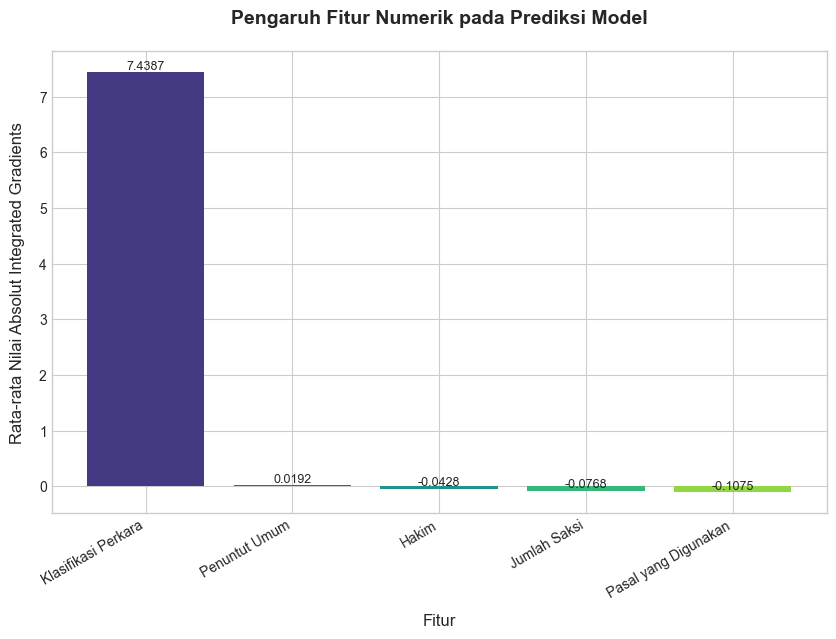

In [31]:

# Plot
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("deep")

# Konfigurasi font 
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Arial', 'DejaVu Sans', 'Liberation Sans']
plt.rcParams['axes.labelsize'] = 12
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['xtick.labelsize'] = 10
plt.rcParams['ytick.labelsize'] = 10

# Fitur numerik
# # Proses Data Numerik
ig_array_numeric = np.array(df_mean)
# mean_ig_numeric = np.mean(np.abs(ig_array_numeric), axis=0)
mean_ig_numeric = np.squeeze(ig_array_numeric)
# mean_ig_numeric = mean_ig_numeric.astype(float)

# Nama fitur numerik
feature_names_num = ['Klasifikasi Perkara', 'Penuntut Umum', 'Hakim', 'Jumlah Saksi', 'Pasal yang Digunakan']

# warna gradien
colors = sns.color_palette("viridis", len(feature_names_num))

fig, ax = plt.subplots(figsize=(10, 6))
bars = ax.bar(range(len(mean_ig_numeric)), mean_ig_numeric, color=colors)

# nilai di atas bar
for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height + 0.001,
            f'{height:.4f}', ha='center', va='bottom', fontsize=9, rotation=0)

ax.set_xticks(range(len(mean_ig_numeric)))
ax.set_xticklabels(feature_names_num, rotation=30, ha='right')
ax.set_title('Pengaruh Fitur Numerik pada Prediksi Model', fontweight='bold', pad=20)
ax.set_xlabel('Fitur', labelpad=10)
ax.set_ylabel('Rata-rata Nilai Absolut Integrated Gradients', labelpad=10)

# # anotasi dan grid
# ax.annotate('Fitur dengan nilai IG lebih tinggi memiliki pengaruh lebih besar pada prediksi model', 
#             xy=(0.5, -0.15), xycoords='axes fraction', ha='center', fontsize=10, fontstyle='italic')
# ax.grid(axis='y', linestyle='--', alpha=0.7)
# fig.tight_layout(pad=2)
plt.show()

In [32]:
np.shape(ig_array_numeric)

(5, 1)

In [33]:
df_mean

,mean_contribution
maks_penjara_berdasarkan_pasal,7.438676
klasifikasi_perkara_encoded,0.019184
jumlah_saksi,-0.042846
hakim_encoded,-0.076830
penuntut_umum_encoded,-0.107506


In [34]:

for exp in all_explanations:
    for feat, val in exp.as_list():
        print(feat, val)

maks_penjara_berdasarkan_pasal=80 -7.2296069339393885
hakim_encoded=0 3.4900906131588187
penuntut_umum_encoded=0 -2.264936231286741
jumlah_saksi=6 1.076714746610059
klasifikasi_perkara_encoded=0 -0.09561779913531836
maks_penjara_berdasarkan_pasal=80 1.595447166724129
penuntut_umum_encoded=1 -0.7996097353823449
hakim_encoded=0 -0.48928681234273846
jumlah_saksi=6 0.2871134196859481
klasifikasi_perkara_encoded=0 -0.03858580624610185
maks_penjara_berdasarkan_pasal=84 -5.410165088344851
penuntut_umum_encoded=1 2.9244978604892116
hakim_encoded=4 1.5100452710927057
jumlah_saksi=3 -0.18012099939874757
klasifikasi_perkara_encoded=0 -0.15282568041228625
maks_penjara_berdasarkan_pasal=144 -3.88106863299605
penuntut_umum_encoded=8 0.8988444202722893
jumlah_saksi=6 -0.3629171978436842
hakim_encoded=0 0.0374990782308411
klasifikasi_perkara_encoded=0 -0.01406761601141837
maks_penjara_berdasarkan_pasal=144 -4.09007949168351
penuntut_umum_encoded=9 0.5650422538327444
jumlah_saksi=6 -0.3898450008539371
